## Project Description

### Overview

This project involves collecting and analyzing data related to adoptable dogs from Petfinder.com, a reputable online database of animals who need homes. The data was collected on October 24th, 2024 using web scraping techniques to gather information on dogs available for adoption in a specific region.

### Source of the Data

- Website: Petfinder.com
- Focus: Adoptable dogs listed on the website
- Location Filter: Data was restricted to dogs available in Atlanta, GA, to maintain a manageable dataset and focus on a specific geographical area

### Data Collected

The following information was collected for each dog:
- Pet ID: A unique identifier assigned by Petfinder
- Name: The name given to the dog by the shelter or rescue organization
- Primary Breed: The primary breed of the dog
- Secondary Breed: The secondary breed of the dog
- Mixed Breed: An indicator (e.g, Yes or No) showing whether the dog is of mixed breed
- Age: Categorized as Baby, Young, Adult, or Senior
- Sex: Male or Female
- Size: The size category of the dog, such as Small, Medium, Large, or Extra Large
- Primary Colour: The predominant color of the dog's coat
- Secondary Colour: The secondary color present in the dog's coat, if any
- Coat Length: The length of the dog's coat, categorized as Hairless, Short, Medium, or Long
- Shelter Name: The name of the shelter or rescue organization currently caring for the dog
- Zip Code: The postal code of the shelter's location
- Number of Photos: The number of photos available for the dog in its listing
- Children: An indicator of whether the dog is suitable for homes with children
- Cats: An indicator of whether the dog gets along well with cats
- Other Dogs: An indicator of whether the dog is friendly towards other dogs
- Characteristics: Descriptive traits and personality attributes of the dog
- House Trained: An indicator of whether the dog is trained to eliminate outside or in designated areas
- Health: Information regarding the dog's health status, including vaccinations, spay/neuter status, and any special needs
- Adoption Fee: The cost associated with adopting the dog, when available

To begin, I am collecting all available data for each dog and will refine the scope during the analysis phase once I determine the specific questions I want to address.

### Decisions to Restrict Data Collection

- Scope Limitation: For proof of concept purposes, data was only collected for adoptable dogs in Atlanta, GA and only three pages worth of data were pulled (119 observations)
- Respecting Terms of Service: Ensured that the scraping process complied with Petfinder's terms of use and robots.txt file
- Error Handling: Implemented exception handling to manage unexpected issues without causing undue strain on the website
- Duplicate Avoidance: Implemented checks to prevent collecting duplicate entries, ensuring each pet is uniquely represented
- Data Validation: Included steps to validate and clean data, such as handling missing values and standardizing formats

## Importing Needed Libraries 

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, TimeoutException, InvalidSelectorException
import pandas as pd
import time
import json
import re
import matplotlib.pyplot as plt
import numpy as np
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor, wait
import threading, queue
from itertools import repeat
from concurrent import futures
from multiprocessing import Pool  # This is a CPU-based Pool
from multiprocessing import cpu_count
import traceback

#-------SCRAPING SPECIFIC MODULES--------
import requests #to conduct different forms of HTTP requests
import html5lib #to construct tree structure of HTML data
from bs4 import BeautifulSoup as soup #to parse the html data obtained from the scrape
import time # to add wait time, to keep the website from kicking us out and also to let the page load before grabbing data
from selenium import webdriver #to automate the navigating within the browser
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select #to select the features we want on the website via the scraper
from selenium.webdriver.support.ui import WebDriverWait #again, to add wait times more 'implicitly'
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options #to use properties of the chrome webbrowser
from selenium.webdriver.remote.command import Command # Use to check whether the web driver is active
from selenium.webdriver.chrome.service import Service
import traceback

## Pulling the Data

In [2]:
def thread_name_fn():
    thread_name_raw = threading.current_thread().name
    thread_name = re.sub(r"ThreadPoolExecutor-\d+_(\d+)", r"ThreadPoolExecutor-0_\1", thread_name_raw)
    return thread_name 

In [3]:
def create_driver_fn(options):
    global drivers_dict
    thread_name = thread_name_fn()
    if thread_name not in drivers_dict:
        service = Service(executable_path=ChromeDriverManager().install())
        drivers_dict[thread_name] = webdriver.Chrome(service=service, options=options)
    driver = drivers_dict[thread_name]
    return driver

In [4]:
def navigate_to_page(driver, page_number):
    current_page = 1
    while current_page < page_number:
        try:
            # Wait for the "Next" button to be clickable
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, '//button[span[text()="Next"]]'))
            )
            # Scroll to the "Next" button and click it
            driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
            next_button.click()
            current_page += 1
            # Wait for the new page of results to load
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, '//a[@class="petCard-link"]'))
            )
            time.sleep(1)  # Short delay to ensure content loads
        except Exception as e:
            print(f"Error navigating to page {page_number}: {e}")
            break

In [5]:
def get_total_pages(driver):
    try:
        # Wait for the custom element to be present
        total_pages_element = WebDriverWait(driver, 30).until(
            EC.presence_of_element_located(
                (By.XPATH, '//*[@id="page-select_List_Box_Btn"]')
            )
        )

        # print('total_pages_element', total_pages_element)
        total_pages_text = total_pages_element.text.strip()
        # print(f"Total pages text: '{total_pages_text}'")
        total_page_result = re.search(r'/(\d+)', total_pages_text)

        total_page = total_page_result.group(1)
        total_page_num = int(total_page)
        return total_page_num

    except Exception as e:
        print(f"Error getting total pages: {e}")
        if 'driver' in locals():
            driver.save_screenshot(f"get_total_pages_error_{int(time.time())}.png")
        traceback.print_exc()
        return 1
    
    

In [6]:
# Function to navigate to the desired page 
def search_dogs(URL, location, driver):
    try:
        # Navigating to the website
        driver.get(URL)

        # Giving the website some time to load (to ensure "Dogs" will set in the animal type search bar) 
        time.sleep(2)

        # Waiting for animal type search bar to load and be ready for interaction 
        form_type = WebDriverWait(driver, 40).until(
            EC.element_to_be_clickable((By.ID, 'simpleSearchAnimalType'))
        )
        form_type.clear()
        form_type.send_keys("Dogs")

        # Finding the location search bar element and ensure it is ready for interaction 
        form_location = WebDriverWait(driver, 40).until(
            EC.element_to_be_clickable((By.ID, 'simpleSearchLocation'))
        )
        form_location.clear()
        form_location.send_keys(location)
        
        # Allowing the location to be set before clicking the search button
        time.sleep(2)

        # Clicking the search button to submit the form
        search_button = WebDriverWait(driver, 40).until(
            EC.element_to_be_clickable((By.ID, 'petSearchBarSearchButton'))
        )
        # search_button = driver.find_element(By.ID, 'petSearchBarSearchButton')
        search_button.click()

        # Wait for the results to load
        WebDriverWait(driver, 40).until(
            EC.presence_of_element_located((By.XPATH, '//a[@class="petCard-link"]'))
        )
        search_results_url = driver.current_url
        print(search_results_url)
        return search_results_url

    except Exception as e:
        print(f"An error occurred while searching for adoptable dogs: {str(e)}")
        print("driver.current_url", driver.current_url)
        if 'driver' in locals():
            driver.save_screenshot(f"search_dogs_error_{int(time.time())}.png")
        traceback.print_exc()
        return None

In [ ]:
def get_info(driver, page_number):
    try:
        dog_data_list = []
        # Creating a list to track missing data for each dog 
        incomplete_data = []
        # Creating a set to keep track of pet IDs 
        processed_pet_ids = set()  

        
        # Waiting for the dog cards to be clickable
        WebDriverWait(driver, 40).until(
            EC.presence_of_all_elements_located((By.XPATH, '//a[@class="petCard-link"]'))
        )
        dog_cards = driver.find_elements(By.XPATH, '//a[@class="petCard-link"]')
        print(f"Found {len(dog_cards)} dog cards on page {page_number}.")

        # Extracting the hrefs from the dog cards
        dog_links = [card.get_attribute('href') for card in dog_cards]

        # Looping through each dog card on the page
        for i, link in enumerate(dog_links):
            # Creating dictionary to store data for each dog 
            dog_info_dict = {}
            try:
                print(f"Processing dog {i + 1} on page {page_number}.")

                # Navigating to the dog detail page
                driver.get(link)

                # Waiting for the dog's detail page to load
                WebDriverWait(driver, 40).until(
                    EC.presence_of_element_located((By.XPATH, '//pf-ad[contains(@id, "PetDetail")]'))
                )

                # Finding the <pf-ad> element that contains the dogs details 
                pf_ad = driver.find_element(By.XPATH, '//pf-ad[contains(@id, "PetDetail")]')
                targeting_data = pf_ad.get_attribute("targeting")
                dog_info = json.loads(targeting_data)

                # Getting the pet ID
                pet_id = dog_info.get('Pet_ID', 'N/A')
                if pet_id == 'N/A':
                    print(f"Pet ID not found for dog {i + 1} on page. Skipping.")
                    continue

                # Checking if pet ID is already processed
                if pet_id in processed_pet_ids:
                    print(f"Pet ID {pet_id} already processed. Skipping dog {i + 1} on page {page_number}.")
                    continue


                # Defining the fields I want and what I want to call the column names
                fields = [
                    ('pet_name', 'Pet_Name'), 
                    ('primary_breed', 'Primary_Breed'), 
                    ('secondary_breed', 'Secondary_Breed'),
                    ('mixed_breed', 'Mixed_Breed'), 
                    ('age', 'Age'), 
                    ('gender', 'Gender'), 
                    ('size', 'Size'), 
                    ('primary_colour', 'Primary_color'), 
                    ('secondary_colour', 'Secondary_color'), 
                    ('coat_length', 'Coat_length'), 
                    ('shelter_name', 'Shelter_Name'), 
                    ('shelter_id', 'Shelter_ID'), 
                    ('zip_code', 'Zip_Code'), 
                    ('num_photos', 'Number_of_photos_in_profile'), 
                    ('children', 'Good_with_children'), 
                    ('cats', 'Good_with_cats'), 
                    ('other_dogs', 'Good_with_dogs'), 
                    ('other_animals', 'Good_with_other_animals'), 
                    ('fee_waived', 'Adoption_fee_waived')
                ]

                # Iterating through each field
                for key, dog_info_key in fields:
                    try:
                        dog_info_dict[key] = dog_info.get(dog_info_key, 'N/A')
                        if dog_info_dict[key] == 'N/A':
                            incomplete_data.append({'pet_id': pet_id, 'field': key, 'error': 'Data not found in JSON'})
                    except Exception as e:
                        dog_info_dict[key] = 'N/A'
                        incomplete_data.append({'pet_id': pet_id, 'field': key, 'error': str(e)})

                # Handling fields that are not in the <pf_ad> tag 
                try:
                    pet_location = driver.find_element('xpath', '//span[@data-test="Pet_Location"]').text
                    dog_info_dict['pet_location'] = pet_location
                except:
                    dog_info_dict['pet_location'] = 'N/A'
                    incomplete_data.append({'pet_id': pet_id, 'field': 'pet_location', 'error': 'Not found on page'})

                try:
                    characteristics = driver.find_element('xpath', '//dt[contains(text(), "Characteristics")]/following-sibling::dd').text
                    dog_info_dict['characteristics'] = characteristics
                except:
                    dog_info_dict['characteristics'] = 'N/A'
                    incomplete_data.append({'pet_id': pet_id, 'field': 'characteristics', 'error': 'Not found on page'})

                try:
                    house_trained = driver.find_element('xpath', '//dt[contains(text(), "House-trained")]/following-sibling::dd').text
                    dog_info_dict['house_trained'] = house_trained
                except:
                    dog_info_dict['house_trained'] = 'N/A'
                    incomplete_data.append({'pet_id': pet_id, 'field': 'house_trained', 'error': 'Not found on page'})

                try:
                    health = driver.find_element('xpath', '//dt[contains(text(), "Health")]/following-sibling::dd').text
                    dog_info_dict['health'] = health
                except:
                    dog_info_dict['health'] = 'N/A'
                    incomplete_data.append({'pet_id': pet_id, 'field': 'health', 'error': 'Not found on page'})

                try:
                    # First, check if the adoption fee is in the about section
                    adoption_fee_element = WebDriverWait(driver, 10).until(
                        EC.presence_of_element_located(
                            (By.XPATH, "//dt[contains(text(), 'Adoption fee')]/following-sibling::dd")
                        )
                    )
                    adoption_fee = adoption_fee_element.text.strip()
                except (NoSuchElementException, TimeoutException, InvalidSelectorException) as e:
                    # If not in the about section, log the error and check the pet story section
                    incomplete_data.append({'pet_id': pet_id, 'field': 'adoption_fee_about_section', 'error': str(e)})
                    try:
                        # Wait for the pet story section to be present
                        pet_story_element = WebDriverWait(driver, 10).until(
                            EC.presence_of_element_located((By.XPATH, '//div[@data-test="Pet_Story_Section"]'))
                        )
                        pet_story_text = pet_story_element.text
                        # Use regex to search for the adoption fee
                        adoption_fee_search = re.search(r'Adoption fee[:\s$]*([\d.,]+)', pet_story_text, re.IGNORECASE)
                        if adoption_fee_search:
                            adoption_fee = adoption_fee_search.group(1)
                        else:
                            adoption_fee = 'N/A'
                            incomplete_data.append({'pet_id': pet_id, 'field': 'adoption_fee_pet_story', 'error': 'Not found in pet story text'})
                    except (NoSuchElementException, TimeoutException) as e:
                        # Log failure in pet story section
                        adoption_fee = 'N/A'
                        incomplete_data.append({'pet_id': pet_id, 'field': 'adoption_fee_pet_story_section', 'error': str(e)})
                else:
                    # If adoption fee was found in the about section, proceed
                    adoption_fee = adoption_fee.strip()
                        
                # Appending a dictionary of all the values for the given dog to the dog_data_list 
                dog_data_list.append(dog_info_dict)
                print(f"Collected data for pet_name {dog_info_dict.get('pet_name', 'N/A')} with pet_id {dog_info_dict.get('pet_id', 'N/A')}")

                # Adding the pet ID to the set of processed IDs
                processed_pet_ids.add(pet_id)

                # Navigating back to the results page
                driver.back()

                # Waiting for dog cards to reload
                WebDriverWait(driver, 40).until(
                    EC.presence_of_all_elements_located((By.XPATH, '//a[@class="petCard-link"]'))
                )

            # Error message if cannot process dog on the given page but continuing with the next dog 
            except Exception as e:
                print(f"Error processing dog {i + 1} on page: {page_number} {e}")
                traceback.print_exc()
                continue

        # Print or store incomplete data information
        if incomplete_data:
            print("Summary of incomplete data fields:")
            for entry in incomplete_data:
                print(entry)

        return dog_data_list

    finally:
        pass


In [8]:
def custom_scraping(options, search_results_url, page_number):
    try:
        service = Service(executable_path=ChromeDriverManager().install())
        driver = webdriver.Chrome(service=service, options=options)

        # Modify the URL to include the page number
        if 'page=' in search_results_url:
            page_url = re.sub(r'page=\d+', f'page={page_number}', search_results_url)
        else:
            delimiter = '&' if '?' in search_results_url else '?'
            page_url = f"{search_results_url}{delimiter}page={page_number}"

        driver.get(page_url)

        # Wait for the page to load
        WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.XPATH, '//a[@class="petCard-link"]'))
        )

        # Extract data from the page
        dog_data_list = get_info(driver, page_number)
        return dog_data_list

    except Exception as e:
        print(f"An error occurred in thread {threading.current_thread().name}: {e}")
        if 'driver' in locals():
            driver.save_screenshot(f"custom_scraping_error_{int(time.time())}.png")
        traceback.print_exc()
        return []
    finally:
        if 'driver' in locals():
            driver.quit()

In [9]:
def main():
    location = "Georgia"
    URL = "https://www.petfinder.com"
    options = Options()
    options.add_argument("headless")


    # Initialize driver to perform the search and get the search results URL
    service = Service(executable_path=ChromeDriverManager().install())
    temp_driver = webdriver.Chrome(service=service, options=options)
    search_results_url = search_dogs(URL, location, temp_driver)

    if not search_results_url:
        print("Failed to get search results URL.")
        return

    # Get total pages
    total_pages = get_total_pages(temp_driver)
    temp_driver.quit()

    print(f"Total pages to scrape: {total_pages}")

    # Generate a list of page numbers
    page_numbers = list(range(1, total_pages + 1))

    # Limit the number of threads to a reasonable amount
    max_workers = min(5, total_pages)

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(custom_scraping, options, search_results_url, page_number)
            for page_number in page_numbers
        ]
        results = []
        for future in concurrent.futures.as_completed(futures):
            try:
                data = future.result()
                results.extend(data)
            except Exception as e:
                print(f"An error occurred: {e}")
                traceback.print_exc()

    print(f"Total dogs collected: {len(results)}")
    # Save results to a file or database here

    # Example of saving to CSV
    if results:
        df = pd.DataFrame(results)
        df.to_csv('georgia_dogs.csv', index=False)
        print("Data saved to georgia_dogs.csv")
    else:
        print("No data collected.")

if __name__ == "__main__":
    main()
    

https://www.petfinder.com/search/dogs-for-adoption/us/georgia/
Total pages to scrape: 117
Found 40 dog cards on page 1.
Found 40 dog cards on page 3.
Found 40 dog cards on page 4.
Processing dog 1 on page 1.
Processing dog 1 on page 3.
Processing dog 1 on page 4.
Found 40 dog cards on page 2.
Found 40 dog cards on page 5.
Collected data for pet_name Diamond  with pet_id 70789208
Processing dog 1 on page 2.
Processing dog 1 on page 5.
Processing dog 2 on page 1.
Collected data for pet_name Helms with pet_id 69627920
Processing dog 3 on page 1.
Collected data for pet_name Richard with pet_id 69618164
Processing dog 4 on page 1.
Collected data for pet_name Lola with pet_id 66652192
Processing dog 2 on page 2.
Collected data for pet_name Chewy with pet_id 73700316
Collected data for pet_name Colt with pet_id 72631343
Collected data for pet_name RAMONA with pet_id 72145543
Processing dog 5 on page 1.
Processing dog 2 on page 4.
Processing dog 2 on page 3.
Collected data for pet_name Stacy w

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 185, in get_info
    driver.back()
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 557, in back
    self.execute(Command.GO_BACK)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 299.996
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104f97648 cxxbridge1$str$ptr + 3645404
1   chromedriver                  

Found 40 dog cards on page 28.
Processing dog 1 on page 28.
Collected data for pet_name Susie 10-0202 with pet_id 73396224
Processing dog 26 on page 25.
Collected data for pet_name Stanley 06-0705 with pet_id 71942813
Collected data for pet_name Phoebe 09-1747 with pet_id 57405815
Processing dog 2 on page 27.
Processing dog 4 on page 26.
Collected data for pet_name Shaye- Neglected rescue girl  looking for love! with pet_id 73756856
Processing dog 2 on page 28.
Collected data for pet_name Jade Elaine 08-1851 with pet_id 56719554
Processing dog 3 on page 27.
Collected data for pet_name Perry 10-0203 with pet_id 73396226
Collected data for pet_name Remy (Sweet tripod baby needs a hero!) with pet_id 73756176
Processing dog 3 on page 28.Processing dog 27 on page 25.

Collected data for pet_name Hamlet 05-3044 with pet_id 71839336
Processing dog 5 on page 26.
Collected data for pet_name Eclipse 07-2461 with pet_id 56446273
Processing dog 4 on page 27.
Collected data for pet_name Tucker -Han

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104f97648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Ursula with pet_id 54135412
Processing dog 27 on page 27.
Collected data for pet_name Chica 6557 with pet_id 73681033
Processing dog 4 on page 29.
Collected data for pet_name Captain Hook 11-2827 with pet_id 70905402
Processing dog 18 on page 26.
Collected data for pet_name Dodger with pet_id 73556654
Processing dog 28 on page 27.
Collected data for pet_name Grover 07-3047 with pet_id 72596750
Processing dog 40 on page 25.
Collected data for pet_name Branch with pet_id 73207237
Collected data for pet_name Bear 0762 with pet_id 73681030
Processing dog 29 on page 27.
Processing dog 5 on page 29.
Collected data for pet_name Black Widow 01-1114 with pet_id 70869208
Processing dog 19 on page 26.
Collected data for pet_name Samadhi with pet_id 72973190
Collected data for pet_name Nova 6444 with pet_id 73664975
Processing dog 30 on page 27.
Processing dog 6 on page 29.
Collected data for pet_name Pandy 07-2341 with pet_id 72504150
Collected data for pet_name Milly 

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104f97648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Quince 09-2144 with pet_id 68993692
Collected data for pet_name Beretta with pet_id 73285313
Processing dog 35 on page 26.
Processing dog 9 on page 31.
Collected data for pet_name Hustle Tag 88 with pet_id 73393944
Processing dog 12 on page 30.
Collected data for pet_name Maxine 7119 with pet_id 72963780
Processing dog 19 on page 29.
Collected data for pet_name Scarlett with pet_id 73284547
Processing dog 10 on page 31.
Collected data for pet_name Helen 07-2648 with pet_id 68953117
Collected data for pet_name Lovely 4860 with pet_id 72858854
Processing dog 36 on page 26.
Processing dog 20 on page 29.
Collected data for pet_name Otis Tag 304 with pet_id 73318196
Collected data for pet_name Martha with pet_id 73259660
Processing dog 11 on page 31.
Processing dog 13 on page 30.
Collected data for pet_name Lottie 07-2429 with pet_id 66261692
Collected data for pet_name Cherry 9523 with pet_id 72827968
Processing dog 37 on page 26.
Processing dog 21 on page 29.
C

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104f97648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Processing dog 26 on page 30.
Collected data for pet_name Muskrat with pet_id 73256968
Processing dog 16 on page 32.
Collected data for pet_name King with pet_id 72597008
Collected data for pet_name Drako with pet_id 73755767
Processing dog 31 on page 31.
Processing dog 27 on page 30.
Collected data for pet_name Sammie Tag 454 with pet_id 73751286
Collected data for pet_name Mishka with pet_id 73204056
Processing dog 37 on page 29.
Processing dog 17 on page 32.
Collected data for pet_name Molly with pet_id 72574301
Collected data for pet_name Tiz with pet_id 73755429
Processing dog 32 on page 31.
Processing dog 28 on page 30.
Collected data for pet_name Jake with pet_id 73169327
Processing dog 18 on page 32.
Collected data for pet_name Bleu with pet_id 72538685
Collected data for pet_name Rupert with pet_id 73755400
Processing dog 33 on page 31.
Processing dog 29 on page 30.
Collected data for pet_name Wiggle Tag 224 with pet_id 73734461
Processing dog 38 on page 29.
Collected data for

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104f97648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Piccolo with pet_id 72270468
Collected data for pet_name Abraham with pet_id 70616598
Processing dog 38 on page 32.
Processing dog 13 on page 33.
Collected data for pet_name Ladybug with pet_id 73085740
Collected data for pet_name Bailey with pet_id 73393707
Processing dog 17 on page 34.
Processing dog 8 on page 35.
Collected data for pet_name Athena with pet_id 72113102
Collected data for pet_name Avali with pet_id 70507922
Processing dog 39 on page 32.
Processing dog 14 on page 33.
Collected data for pet_name Ellie with pet_id 73134731Collected data for pet_name Mason with pet_id 73716409

Processing dog 9 on page 35.
Processing dog 18 on page 34.
Collected data for pet_name Tyson with pet_id 71809761
Collected data for pet_name Jerry FOSTER NEEDED TOO! with pet_id 70275551
Processing dog 40 on page 32.
Processing dog 15 on page 33.
Collected data for pet_name Mick with pet_id 73134624
Collected data for pet_name Raven with pet_id 73716410
Processing dog 1

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104f97648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Lola with pet_id 73305504
Processing dog 22 on page 35.
Collected data for pet_name Rusty with pet_id 61761614
Collected data for pet_name Wesley with pet_id 73716448
Processing dog 20 on page 36.
Processing dog 38 on page 34.
Collected data for pet_name Ridley with pet_id 72338113
Processing dog 35 on page 33.
Collected data for pet_name Sullivan with pet_id 73280210
Processing dog 23 on page 35.
Collected data for pet_name Sully with pet_id 60836279
Collected data for pet_name Jordan with pet_id 73716450
Processing dog 21 on page 36.
Processing dog 39 on page 34.
Collected data for pet_name Bertie with pet_id 71149417
Processing dog 36 on page 33.
Collected data for pet_name Boo with pet_id 60836278
Collected data for pet_name Karen with pet_id 73716451
Processing dog 22 on page 36.
Processing dog 40 on page 34.
Collected data for pet_name Remy with pet_id 71144357
Collected data for pet_name Squirtle with pet_id 73237464
Processing dog 37 on page 33.
Proc

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104f97648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Processing dog 3 on page 39.
Collected data for pet_name 2024-10-145 *Kennedy* with pet_id 73696248
Processing dog 25 on page 38.
Collected data for pet_name Addison with pet_id 72589156
Processing dog 37 on page 35.
Collected data for pet_name Smiley with pet_id 71469030
Processing dog 39 on page 36.
Collected data for pet_name 2024-10-012 *BeBe* with pet_id 73395733
Collected data for pet_name Zap with pet_id 72589159
Processing dog 4 on page 39.
Processing dog 38 on page 35.
Collected data for pet_name 2024-10-150 *Bobo* with pet_id 73696246
Processing dog 26 on page 38.
Collected data for pet_name Josie with pet_id 71469029
Processing dog 40 on page 36.
Collected data for pet_name Dawson with pet_id 71435104
Collected data for pet_name 2024-10-005 *Roman* with pet_id 73366112
Collected data for pet_name Captain Marvel with pet_id 72584694
Processing dog 5 on page 39.
Processing dog 39 on page 35.
Found 40 dog cards on page 40.
Processing dog 1 on page 40.
Collected data for pet_nam

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104f97648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Processing dog 12 on page 40.
Collected data for pet_name Vc-4c Groot with pet_id 73743851
Processing dog 17 on page 41.
Collected data for pet_name Vc-12c with pet_id 73743863
Collected data for pet_name 2024-09-032 *Addie* with pet_id 73507856
Processing dog 18 on page 41.
Processing dog 39 on page 38.
Collected data for pet_name 2023-07-179 *Hoover* with pet_id 72779628
Collected data for pet_name 2023-10-191 with pet_id 69467055
Processing dog 17 on page 39.
Processing dog 13 on page 40.
Collected data for pet_name Pen 190 Cupcake with pet_id 73743846
Processing dog 19 on page 41.
Collected data for pet_name 2024-08-006 with pet_id 73507853
Collected data for pet_name Pen 210 Leopard with pet_id 73743845
Processing dog 40 on page 38.
Collected data for pet_name 2024-07-192 *Princess* with pet_id 72620500
Collected data for pet_name 2023-08-175 with pet_id 69243207
Processing dog 20 on page 41.
Processing dog 14 on page 40.
Processing dog 18 on page 39.
Collected data for pet_name P

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104f97648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Processing dog 29 on page 39.
Processing dog 37 on page 40.
Collected data for pet_name Pen 217 Pumpkin with pet_id 73675911
Collected data for pet_name Pen 185c Bits with pet_id 73726928
Processing dog 18 on page 42.
Processing dog 39 on page 41.
Collected data for pet_name Avery with pet_id 73198555
Processing dog 38 on page 40.
Collected data for pet_name Pen 222 Cowboy with pet_id 73675913
Processing dog 19 on page 42.
Collected data for pet_name Ic-1 with pet_id 73714905
Collected data for pet_name 2024-06-111 *Athena* with pet_id 72008851
Processing dog 40 on page 41.
Processing dog 30 on page 39.
Collected data for pet_name Pen 136c Figgy with pet_id 73671336
Processing dog 20 on page 42.
Collected data for pet_name Pen 214 with pet_id 73714906
Found 40 dog cards on page 43.
Processing dog 1 on page 43.
Collected data for pet_name Hailey with pet_id 73068828
Processing dog 39 on page 40.
Collected data for pet_name 2024-06-114 *Tammy* with pet_id 72008847
Collected data for pet_

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104f97648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Pen 138c Butter with pet_id 73552444
Processing dog 40 on page 42.
Collected data for pet_name Pen 176 Missy with pet_id 72838171
Processing dog 3 on page 45.
Collected data for pet_name Pen 137 Crispy with pet_id 73426313
Processing dog 21 on page 43.
Collected data for pet_name Pen 114 Tobias with pet_id 72838198
Processing dog 20 on page 44.
Collected data for pet_name Pen 195 Ace with pet_id 73526988
Collected data for pet_name Destin with pet_id 73730035
Processing dog 4 on page 45.
Found 40 dog cards on page 46.
Processing dog 1 on page 46.
Collected data for pet_name Pen 165 Tilly Hw + with pet_id 73426316
Processing dog 22 on page 43.
Collected data for pet_name Pen 155 Velzy with pet_id 72838213
Processing dog 21 on page 44.
Collected data for pet_name Duke with pet_id 73730036
Collected data for pet_name Faire with pet_id 73496308
Processing dog 5 on page 45.
Processing dog 2 on page 46.
Collected data for pet_name Pen 199 Norbert with pet_id 73426

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104f97648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Milo with pet_id 73619941
Found 40 dog cards on page 48.
Processing dog 1 on page 48.
Processing dog 18 on page 46.
Collected data for pet_name MISS. ZUMA with pet_id 71794918
Processing dog 26 on page 45.
Collected data for pet_name SPOOKY VON SKELLINGTON with pet_id 72377346
Processing dog 3 on page 47.
Collected data for pet_name ENZO with pet_id 71794917
Processing dog 27 on page 45.
Collected data for pet_name Belle with pet_id 73334655
Collected data for pet_name Oakley with pet_id 73601109
Collected data for pet_name SCOOBY with pet_id 72377350
Processing dog 2 on page 48.
Processing dog 19 on page 46.
Processing dog 4 on page 47.
Collected data for pet_name KELSO with pet_id 71794916
Processing dog 28 on page 45.
Collected data for pet_name BENNY with pet_id 72377354
Processing dog 5 on page 47.
Collected data for pet_name JOSEPHINE with pet_id 71794920
Collected data for pet_name Hopper with pet_id 73334660
Collected data for pet_name Maggie with pe

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104f97648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Processing dog 2 on page 50.
Collected data for pet_name QUINCY with pet_id 71295193
Collected data for pet_name Merlin with pet_id 64512020
Processing dog 25 on page 47.
Processing dog 25 on page 48.
Collected data for pet_name Lottie with pet_id 64510957
Processing dog 26 on page 48.
Collected data for pet_name Cruz with pet_id 73532168
Processing dog 5 on page 49.
Collected data for pet_name My`lena with pet_id 73400971
Collected data for pet_name DAISY MAE with pet_id 71120674
Processing dog 3 on page 50.
Processing dog 26 on page 47.
Collected data for pet_name Baker with pet_id 73532167
Processing dog 6 on page 49.
Collected data for pet_name Makarlee with pet_id 73400890
Collected data for pet_name Citrine with pet_id 73746856
Collected data for pet_name CHIEF with pet_id 71016492
Processing dog 4 on page 50.
Processing dog 27 on page 48.
Processing dog 27 on page 47.
Collected data for pet_name Gumbo with pet_id 73493449
Processing dog 7 on page 49.
Collected data for pet_name 

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104f97648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Zoot (TA) ADOPTED with pet_id 73401000
Processing dog 24 on page 50.
Processing dog 24 on page 49.
Collected data for pet_name Cloudy with pet_id 73681089
Collected data for pet_name Bluee with pet_id 73400815
Processing dog 39 on page 48.
Processing dog 7 on page 51.
Collected data for pet_name Hocus Pocus with pet_id 73400954
Collected data for pet_name Caterpillar with pet_id 73401007
Processing dog 25 on page 50.
Processing dog 25 on page 49.
Collected data for pet_name Ni Ni with pet_id 73681088
Collected data for pet_name Morgan (in foster) with pet_id 73400763
Processing dog 8 on page 51.
Processing dog 40 on page 48.
Collected data for pet_name Koala with pet_id 73400950
Collected data for pet_name Callum(In-Foster) with pet_id 73400905
Processing dog 26 on page 50.
Processing dog 26 on page 49.
Collected data for pet_name Sue with pet_id 73652879
Collected data for pet_name Solomon with pet_id 73400857
Processing dog 9 on page 51.
Found 40 dog cards

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104f97648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Processing dog 10 on page 53.
Collected data for pet_name Betsy with pet_id 69447356
Collected data for pet_name Josh with pet_id 73400782
Processing dog 11 on page 53.
Processing dog 27 on page 51.
Collected data for pet_name Mahala with pet_id 73400723
Collected data for pet_name Karen with pet_id 69248311
Processing dog 19 on page 52.
Processing dog 12 on page 53.
Collected data for pet_name Cronkite (Trial Adoption) with pet_id 73400801
Processing dog 28 on page 51.
Collected data for pet_name Chatham with pet_id 73400727
Collected data for pet_name May with pet_id 51932821
Collected data for pet_name Risty with pet_id 73754479
Processing dog 20 on page 52.
Processing dog 13 on page 53.
Processing dog 3 on page 54.
Collected data for pet_name Benjamin with pet_id 73400822
Processing dog 29 on page 51.
Collected data for pet_name Poe (in Foster) with pet_id 73400731
Collected data for pet_name Ralphie with pet_id 72263232
Processing dog 21 on page 52.
Processing dog 14 on page 53.
C

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 188, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Garnet with pet_id 68997040
Collected data for pet_name 57176903 with pet_id 73743135
Collected data for pet_name Eliza with pet_id 73038309Collected data for pet_name Gerado with pet_id 73400839

Processing dog 20 on page 53.
Processing dog 10 on page 54.
Processing dog 39 on page 51.Processing dog 30 on page 52.

Collected data for pet_name Sally with pet_id 68996852
Processing dog 21 on page 53.
Collected data for pet_name Sammy (foster) with pet_id 73400838
Collected data for pet_name Zane with pet_id 73599188
Processing dog 40 on page 51.
Processing dog 31 on page 52.
Collected data for pet_name Soks with pet_id 64727886
Processing dog 22 on page 53.
Collected data for pet_name Butters with pet_id 56811760
Processing dog 23 on page 53.
Collected data for pet_name Pink with pet_id 42601488
Processing dog 24 on page 53.
Collected data for pet_name Rao with pet_id 73741575
Processing dog 11 on page 54.
Collected data for pet_name Jackfruit with pet_id 7340

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104f97648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name G.G. with pet_id 73538542
Processing dog 40 on page 52.
Collected data for pet_name Reese with pet_id 73234453
Collected data for pet_name Subaru with pet_id 73713869
Processing dog 5 on page 55.
Collected data for pet_name Shadow with pet_id 73757868
Collected data for pet_name Scales with pet_id 73729142
Processing dog 16 on page 54.
Processing dog 29 on page 53.
Found 40 dog cards on page 56.
Processing dog 1 on page 56.
Collected data for pet_name Bass with pet_id 73713868
Processing dog 6 on page 55.
Collected data for pet_name Jezarae with pet_id 73725412
Collected data for pet_name 57184218 with pet_id 73757869
Collected data for pet_name Tandro - Orange - IN FOSTER with pet_id 73681710
Processing dog 17 on page 54.
Processing dog 30 on page 53.
Processing dog 2 on page 56.
Collected data for pet_name Snowdrop with pet_id 73713867
Processing dog 7 on page 55.
Collected data for pet_name Kiko - IN FOSTER with pet_id 73757530
Processing dog 31 on page 5

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104f97648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Cherry Blossom- ADOPTED with pet_id 73642540
Processing dog 2 on page 57.
Collected data for pet_name Black Panther with pet_id 73715404
Processing dog 29 on page 54.
Collected data for pet_name Celeste with pet_id 73704092
Processing dog 19 on page 55.
Collected data for pet_name Pawsey with pet_id 73666979
Processing dog 14 on page 56.
Collected data for pet_name Bronco-ADOPTED with pet_id 73642539
Processing dog 3 on page 57.
Collected data for pet_name Nutello with pet_id 73715399
Processing dog 30 on page 54.
Collected data for pet_name Thomas with pet_id 73665603
Processing dog 15 on page 56.
Collected data for pet_name Meadowlark with pet_id 73704091
Processing dog 20 on page 55.
Collected data for pet_name Grape (purple) with pet_id 73642542
Processing dog 4 on page 57.
Collected data for pet_name Gravy with pet_id 73715398
Processing dog 31 on page 54.
Collected data for pet_name Aaliyah-ADOPTED with pet_id 73656697
Processing dog 16 on page 56.
Col

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104f97648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Processing dog 31 on page 55.
Collected data for pet_name Titas with pet_id 73652926
Processing dog 27 on page 56.
Collected data for pet_name Camille - IN FOSTER with pet_id 73629548
Processing dog 16 on page 57.
Collected data for pet_name Mitsubishi with pet_id 73601284
Processing dog 2 on page 58.
Collected data for pet_name Lady Bug with pet_id 73704073
Processing dog 32 on page 55.
Collected data for pet_name Grogu with pet_id 73652928
Processing dog 28 on page 56.
Collected data for pet_name Chinky with pet_id 73628773
Processing dog 17 on page 57.
Collected data for pet_name Nissan with pet_id 73601277
Processing dog 3 on page 58.
Collected data for pet_name Pacho with pet_id 73704076
Processing dog 33 on page 55.
Collected data for pet_name Patagonia with pet_id 73652925
Processing dog 29 on page 56.
Collected data for pet_name Skale with pet_id 73628772
Processing dog 18 on page 57.
Collected data for pet_name Doraemon with pet_id 73601280
Processing dog 4 on page 58.
Collect

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104f97648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Manima with pet_id 73557022
Collected data for pet_name Siberia with pet_id 73617668
Processing dog 4 on page 59.
Processing dog 29 on page 57.
Collected data for pet_name Macaw with pet_id 73588731
Processing dog 15 on page 58.
Collected data for pet_name Dog Wood -IN FOSTER with pet_id 73642544
Found 40 dog cards on page 60.
Processing dog 1 on page 60.
Collected data for pet_name Chi Chu with pet_id 73556082
Collected data for pet_name Okapi with pet_id 73617665
Processing dog 5 on page 59.
Processing dog 30 on page 57.
Collected data for pet_name Panama with pet_id 73587505
Processing dog 16 on page 58.
Collected data for pet_name Tinkerbell- IN FOSTER with pet_id 73507062
Processing dog 2 on page 60.
Collected data for pet_name Otter with pet_id 73550502
Processing dog 6 on page 59.
Collected data for pet_name Svetka with pet_id 73617662
Collected data for pet_name Bessie with pet_id 73586201
Processing dog 31 on page 57.
Processing dog 17 on page 58.
C

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104f97648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Antonio with pet_id 73449900
Processing dog 3 on page 61.
Collected data for pet_name Grass with pet_id 73532169
Processing dog 18 on page 59.
Collected data for pet_name Skooli with pet_id 73491259
Collected data for pet_name Swiss with pet_id 73573918
Processing dog 14 on page 60.
Processing dog 29 on page 58.
Collected data for pet_name Alto - IN FOSTER with pet_id 73449897
Processing dog 4 on page 61.
Collected data for pet_name Spurt with pet_id 73531393
Processing dog 19 on page 59.
Collected data for pet_name Mixie with pet_id 73489356
Collected data for pet_name Dior with pet_id 73572224
Processing dog 15 on page 60.
Processing dog 30 on page 58.
Collected data for pet_name Manchester with pet_id 73437384
Processing dog 5 on page 61.
Collected data for pet_name Astara with pet_id 73531390
Processing dog 20 on page 59.
Collected data for pet_name Birdo with pet_id 73479802
Processing dog 16 on page 60.
Collected data for pet_name Liberty with pet_id 7

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104f97648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Tiptoe with pet_id 73520484
Processing dog 30 on page 59.
Found 40 dog cards on page 63.
Processing dog 1 on page 63.
Collected data for pet_name Maybeleene with pet_id 73378134
Processing dog 2 on page 62.
Collected data for pet_name Chansey with pet_id 73407675
Collected data for pet_name Linny with pet_id 73465924
Processing dog 17 on page 61.
Processing dog 28 on page 60.
Collected data for pet_name Zorba with pet_id 73520483
Collected data for pet_name Sheela- ADOPTED with pet_id 73378130
Processing dog 31 on page 59.
Processing dog 3 on page 62.
Collected data for pet_name Clove with pet_id 73272824
Processing dog 2 on page 63.
Collected data for pet_name Cognac with pet_id 73407678
Collected data for pet_name Gilly with pet_id 73272814
Collected data for pet_name HedgeHog with pet_id 73465922
Processing dog 18 on page 61.
Processing dog 3 on page 63.
Processing dog 29 on page 60.
Collected data for pet_name Kijah IN FOSTER with pet_id 73368557
Collect

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 188, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Parc with pet_id 73394928
Processing dog 29 on page 61.
Collected data for pet_name Alpaca - ADOPTED with pet_id 73452307
Processing dog 39 on page 60.
Collected data for pet_name Lula - IN FOSTER with pet_id 73212622
Collected data for pet_name Oberon- IN FOSTER with pet_id 73508741
Processing dog 16 on page 63.
Processing dog 40 on page 59.
Collected data for pet_name 57012029 with pet_id 73392164
Processing dog 30 on page 61.
Collected data for pet_name Latchy with pet_id 73452308
Processing dog 40 on page 60.
Collected data for pet_name Chepp - IN FOSTER with pet_id 73203425
Collected data for pet_name Zebu -ADOPTED with pet_id 73507064
Processing dog 17 on page 63.
Found 40 dog cards on page 64.
Processing dog 1 on page 64.
Collected data for pet_name Bandit with pet_id 73392162
Processing dog 31 on page 61.
Collected data for pet_name Mani - IN FOSTER with pet_id 73177730
Processing dog 2 on page 64.
Collected data for pet_name Gunner- IN FOSTER with p

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 299.633
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000102afb648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Processing dog 7 on page 64.
Collected data for pet_name Cowly with pet_id 73075945
Processing dog 8 on page 65.
Collected data for pet_name Tither with pet_id 73380672
Collected data for pet_name Arrow with pet_id 73201046
Processing dog 37 on page 61.
Processing dog 24 on page 63.
Collected data for pet_name Tahiti with pet_id 73166872
Collected data for pet_name Sylvan with pet_id 73075944
Processing dog 8 on page 64.
Processing dog 9 on page 65.
Collected data for pet_name Valkyrie with pet_id 73380674
Processing dog 38 on page 61.
Collected data for pet_name Heather - IN FOSTER with pet_id 73187897
Processing dog 25 on page 63.
Collected data for pet_name Barnaby - IN FOSTER with pet_id 73165206
Collected data for pet_name Elmo - IN FOSTER ADOPTED with pet_id 73065725
Processing dog 9 on page 64.
Processing dog 10 on page 65.
Collected data for pet_name Hype with pet_id 73380668
Processing dog 39 on page 61.
Collected data for pet_name Asta- IN FOSTER with pet_id 73052689
Collecte

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000102afb648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Junior with pet_id 73128533
Collected data for pet_name Sloth with pet_id 73179968
Processing dog 22 on page 64.
Processing dog 38 on page 63.
Collected data for pet_name Benny Shapiro - IN FOSTER with pet_id 72942564
Collected data for pet_name Summitt with pet_id 73031300
Processing dog 13 on page 66.
Processing dog 25 on page 65.
Collected data for pet_name Gizzy with pet_id 73179967
Processing dog 39 on page 63.
Collected data for pet_name Ocean with pet_id 72942563
Processing dog 14 on page 66.
Collected data for pet_name Frittata - IN FOSTER with pet_id 73126159
Processing dog 23 on page 64.
Collected data for pet_name Zelma with pet_id 73031293
Processing dog 26 on page 65.
Collected data for pet_name Minty - ADOPTED with pet_id 72939753
Processing dog 15 on page 66.
Collected data for pet_name Sargentina - IN FOSTER with pet_id 73178738
Processing dog 40 on page 63.
Collected data for pet_name Tangelo- IN FOSTER with pet_id 73031284
Processing dog 27

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000102afb648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Processing dog 37 on page 64.
Collected data for pet_name McDougal with pet_id 72875948
Processing dog 15 on page 67.
Collected data for pet_name Juliet with pet_id 72928330
Processing dog 31 on page 66.
Collected data for pet_name Joseph - IN FOSTER with pet_id 72794700
Processing dog 2 on page 68.
Collected data for pet_name KeeKo- FTF ADOPTION with pet_id 73105881
Processing dog 38 on page 64.
Collected data for pet_name Jugger - IN FOSTER with pet_id 72875946
Collected data for pet_name Starburst with pet_id 72928315
Processing dog 16 on page 67.
Processing dog 32 on page 66.
Collected data for pet_name Tracey with pet_id 72792671
Processing dog 3 on page 68.
Collected data for pet_name Tillie - ADOPTED with pet_id 73104588
Processing dog 39 on page 64.
Collected data for pet_name Bartise - IN FOSTER with pet_id 72860469
Collected data for pet_name Araminta with pet_id 72928323
Processing dog 17 on page 67.
Collected data for pet_name Ernie - IN FOSTER WW with pet_id 72790967
Proce

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000102afb648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Layton - IN FOSTER with pet_id 72426621
Processing dog 8 on page 70.
Collected data for pet_name Franky- IN FOSTER with pet_id 72708355
Collected data for pet_name Ellie with pet_id 72825393
Processing dog 18 on page 68.
Processing dog 33 on page 67.
Collected data for pet_name Dagger- IN FOSTER with pet_id 72555731
Collected data for pet_name Alexis- IN FOSTER with pet_id 72426611
Processing dog 9 on page 70.
Processing dog 16 on page 69.
Collected data for pet_name Shakira with pet_id 72555737
Collected data for pet_name Lenora - IN FOSTER with pet_id 72702223
Processing dog 17 on page 69.
Processing dog 19 on page 68.
Collected data for pet_name CeeCee with pet_id 72814626
Processing dog 34 on page 67.
Collected data for pet_name Lloyd - IN FOSTER with pet_id 72426601
Processing dog 10 on page 70.
Collected data for pet_name Farley with pet_id 72544220
Processing dog 18 on page 69.
Collected data for pet_name Zane with pet_id 72700753
Collected data for p

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000102afb648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Wildflower with pet_id 72659866
Collected data for pet_name Vegas with pet_id 72500949
Processing dog 33 on page 68.
Collected data for pet_name Eugene - IN FOSTER with pet_id 72375679
Processing dog 33 on page 69.
Processing dog 27 on page 70.
Collected data for pet_name Miss Bumblebee- IN FOSTER with pet_id 72283926
Processing dog 13 on page 71.
Collected data for pet_name Rino- IN FOSTER with pet_id 72653350
Processing dog 34 on page 68.
Collected data for pet_name Dodger - IN FOSTER with pet_id 72276832
Processing dog 14 on page 71.
Collected data for pet_name Rollie - ADOPTED with pet_id 72500946
Collected data for pet_name Columbiana - IN FOSTER with pet_id 72641533
Collected data for pet_name Rose-Marie with pet_id 72364009
Processing dog 34 on page 69.
Processing dog 35 on page 68.
Processing dog 28 on page 70.
Collected data for pet_name Amberly with pet_id 72276418
Processing dog 15 on page 71.
Collected data for pet_name Ada with pet_id 72500945
P

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000102afb648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Camacho- IN FOSTER with pet_id 71593918
Processing dog 4 on page 74.
Collected data for pet_name Jayjay - IN FOSTER with pet_id 72049552
Processing dog 12 on page 72.
Collected data for pet_name Broussard - IN FOSTER with pet_id 71863383
Processing dog 12 on page 73.
Collected data for pet_name Treasure- IN FOSTER with pet_id 72200639
Collected data for pet_name Taylor Hautner - IN FOSTER with pet_id 72049543
Processing dog 32 on page 71.
Processing dog 13 on page 72.
Collected data for pet_name Rosalina with pet_id 71859657
Processing dog 13 on page 73.
Collected data for pet_name Lamario- IN FOSTER with pet_id 71581233
Processing dog 5 on page 74.
Collected data for pet_name Brett - IN FOSTER with pet_id 72047975
Collected data for pet_name Daytona with pet_id 72200635
Processing dog 14 on page 72.
Processing dog 33 on page 71.
Collected data for pet_name Salt - IN FOSTER with pet_id 71848598
Processing dog 14 on page 73.
Collected data for pet_name Jassy-

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000102afb648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Mabel - IN FOSTER with pet_id 71706593
Processing dog 31 on page 73.
Collected data for pet_name Jyona- IN FOSTER with pet_id 70970542
Collected data for pet_name Speck-IN FOSTER with pet_id 71950716
Processing dog 11 on page 75.
Processing dog 32 on page 72.
Collected data for pet_name Olivia - IN FOSTER with pet_id 71387400
Processing dog 22 on page 74.
Collected data for pet_name Lexi- IN FOSTER with pet_id 71698059
Processing dog 32 on page 73.
Collected data for pet_name Kathrine with pet_id 70962883
Processing dog 12 on page 75.
Collected data for pet_name Ivory- IN FOSTER with pet_id 71358871
Processing dog 23 on page 74.
Collected data for pet_name Hecate- IN FOSTER with pet_id 71947270
Processing dog 33 on page 72.
Collected data for pet_name Sonder - IN FOSTER with pet_id 70947241
Processing dog 13 on page 75.
Collected data for pet_name Lemoja- IN FOSTER with pet_id 71352802
Processing dog 24 on page 74.
Collected data for pet_name Ravioli with pe

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000102afb648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Jakina -IN FOSTER with pet_id 69734215
Collected data for pet_name Solaria - IN FOSTER with pet_id 71043155
Processing dog 9 on page 77.
Processing dog 39 on page 74.
Collected data for pet_name MIA - Silverbell -ADOPTED FTA with pet_id 70340954
Processing dog 10 on page 76.
Collected data for pet_name Lightspeed-IN FOSTER with pet_id 69718527
Collected data for pet_name Lamaia- IN FOSTER with pet_id 70703818
Collected data for pet_name Lyra- IN FOSTER with pet_id 71029416
Processing dog 10 on page 77.
Processing dog 30 on page 75.
Processing dog 40 on page 74.
Collected data for pet_name Potassium - IN FOSTER WW with pet_id 70331489
Processing dog 11 on page 76.
Collected data for pet_name Jinkey - IN FOSTER with pet_id 69708105
Collected data for pet_name Tenna- IN FOSTER with pet_id 71027184
Processing dog 11 on page 77.
Found 40 dog cards on page 78.
Processing dog 1 on page 78.
Collected data for pet_name Shayla - IN FOSTER with pet_id 70327285
Processi

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000102afb648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Gentle Ben- IN FOSTER with pet_id 66294048
Processing dog 16 on page 78.
Collected data for pet_name Soul- IN FOSTER with pet_id 70071602
Collected data for pet_name Chevin - IN FOSTER with pet_id 69429618
Processing dog 30 on page 76.
Collected data for pet_name Harlem - IN FOSTER with pet_id 64363512
Processing dog 28 on page 77.
Processing dog 8 on page 79.
Collected data for pet_name Leelee-IN FOSTER with pet_id 66282347
Processing dog 17 on page 78.
Collected data for pet_name Lithia - IN FOSTER with pet_id 70065238
Collected data for pet_name Davelia- In Foster with pet_id 69401231
Processing dog 31 on page 76.
Collected data for pet_name Feldspar - IN FOSTER with pet_id 64123295
Processing dog 29 on page 77.
Processing dog 9 on page 79.
Collected data for pet_name Kilo Kilo - IN FOSTER with pet_id 66281488
Processing dog 18 on page 78.
Collected data for pet_name Fiesta-IN FOSTER with pet_id 70036833
Collected data for pet_name Johansen - IN FOSTER wi

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000102afb648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Processing dog 9 on page 80.
Collected data for pet_name Herkimo - IN FOSTER with pet_id 65098644
Collected data for pet_name Rayven with pet_id 70246871
Processing dog 36 on page 78.
Processing dog 6 on page 81.
Collected data for pet_name Stevie - IN FOSTER with pet_id 62927530
Collected data for pet_name Dazjah - IN FOSTER with pet_id 62928886
Processing dog 10 on page 80.
Processing dog 28 on page 79.
Collected data for pet_name Misty- IN FOSTER with pet_id 64986247
Collected data for pet_name Reesa with pet_id 70246528
Processing dog 37 on page 78.
Processing dog 7 on page 81.
Collected data for pet_name Nimbus- IN FOSTER with pet_id 62926536
Collected data for pet_name Huckle Barkle Finn - IN FOSTER with pet_id 62929108
Processing dog 29 on page 79.
Processing dog 11 on page 80.
Collected data for pet_name Arlo with pet_id 70246470
Collected data for pet_name Oliviana - IN FOSTER with pet_id 64944825
Processing dog 8 on page 81.
Processing dog 38 on page 78.
Collected data for pe

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.WebDriverException: Message: disconnected: Unable to receive message from renderer
  (failed to check if window was closed: disconnected: not connected to DevTools)
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                 

Error processing dog 15 on page: 81 Message: disconnected: not connected to DevTools
  (failed to check if window was closed: disconnected: not connected to DevTools)
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000102ddb648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x0000000102dd3ea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x0000000102840104 cxxbridge1$string$len + 88416
3   chromedriver                        0x000000010282a3d0 core::str::slice_error_fail::h1cab30ac4b13c655 + 63280
4   chromedriver                        0x000000010282a310 core::str::slice_error_fail::h1cab30ac4b13c655 + 63088
5   chromedriver                        0x00000001028bb654 cxxbridge1$string$len + 593584
6   chromedriver                        0x0000000102876f54 cxxbridge1$string$len + 313264
7   chromedriver                        0x0000000102877ba4 cxxbridge1$string$len + 316416
8   chromedriver   

Traceback (most recent call last):
Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.WebDriverException: Message: disconnected: not connected to DevTools
  (failed to check if window was closed: disconnected: not connected to DevTools)
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedr

Error processing dog 25 on page: 80 Message: disconnected: not connected to DevTools
  (failed to check if window was closed: disconnected: not connected to DevTools)
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x000000010513f648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x0000000105137ea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x0000000104ba4104 cxxbridge1$string$len + 88416
3   chromedriver                        0x0000000104b8e3d0 core::str::slice_error_fail::h1cab30ac4b13c655 + 63280
4   chromedriver                        0x0000000104b8e310 core::str::slice_error_fail::h1cab30ac4b13c655 + 63088
5   chromedriver                        0x0000000104c1f654 cxxbridge1$string$len + 593584
6   chromedriver                        0x0000000104bdaf54 cxxbridge1$string$len + 313264
7   chromedriver                        0x0000000104bdbba4 cxxbridge1$string$len + 316416
8   chromedriver   

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.WebDriverException: Message: disconnected: not connected to DevTools
  (failed to check if window was closed: disconnected: not connected to DevTools)
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000

Error processing dog 30 on page: 80 Message: disconnected: not connected to DevTools
  (failed to check if window was closed: disconnected: not connected to DevTools)
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x000000010513f648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x0000000105137ea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x0000000104ba4104 cxxbridge1$string$len + 88416
3   chromedriver                        0x0000000104b8e3d0 core::str::slice_error_fail::h1cab30ac4b13c655 + 63280
4   chromedriver                        0x0000000104b8e310 core::str::slice_error_fail::h1cab30ac4b13c655 + 63088
5   chromedriver                        0x0000000104c1f654 cxxbridge1$string$len + 593584
6   chromedriver                        0x0000000104bdaf54 cxxbridge1$string$len + 313264
7   chromedriver                        0x0000000104bdbba4 cxxbridge1$string$len + 316416
8   chromedriver   

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 33, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 
Stacktrace:
0   chromedriver                        0x000000010075b648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x0000000100753ea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x00000001001c0104 cxxbridge1$string$len + 88416
3   chromedriver                        0x0000000100202364 cxxbridge1$string$len + 359360
4   chromedriver                        0x000000010023bbd0 cxxbridge1$string$len + 594988
5   chromedriver                        0x00000001001f6f54 cxxbridge1$string$len + 313264
6   chromedriver               

Processing dog 10 on page 97.
Collected data for pet_name Blue Moon with pet_id 73434627
Processing dog 19 on page 93.
Collected data for pet_name Foxy with pet_id 73434567
Collected data for pet_name Primo with pet_id 73434496
Processing dog 15 on page 94.
Processing dog 13 on page 95.
Collected data for pet_name calyssa with pet_id 73434341
Collected data for pet_name Maylene with pet_id 73434605
Collected data for pet_name Emlou - IN FOSTER with pet_id 73434335
Collected data for pet_name Bourbon with pet_id 73434503
Processing dog 16 on page 94.
Processing dog 11 on page 97.
Processing dog 14 on page 95.
Collected data for pet_name Ancelle with pet_id 73434596
Processing dog 20 on page 93.
Collected data for pet_name LuLuLemon (Lemi) with pet_id 73434302
Collected data for pet_name Janie with pet_id 73434654
Processing dog 12 on page 97.
Processing dog 17 on page 94.
Collected data for pet_name Marshall with pet_id 73434690
Processing dog 21 on page 93.
Collected data for pet_name 

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 188, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Onya with pet_id 73434584
Collected data for pet_name Sawyer with pet_id 73434661
Processing dog 19 on page 94.
Processing dog 23 on page 93.
Collected data for pet_name Sweetie Pie with pet_id 73434413
Processing dog 14 on page 97.
Collected data for pet_name HUEY LEWIS - IN FOSTER with pet_id 73434560
Processing dog 20 on page 94.
Collected data for pet_name Melissa with pet_id 73434382
Collected data for pet_name Dani with pet_id 73434509
Processing dog 17 on page 95.
Processing dog 13 on page 96.
Collected data for pet_name Pickles (FKA Marla) with pet_id 73434645
Processing dog 24 on page 93.
Collected data for pet_name Rick Sanchez with pet_id 73434445
Collected data for pet_name Catherine The Great with pet_id 73434327
Collected data for pet_name Jason Bourne with pet_id 73434394Processing dog 18 on page 95.

Processing dog 15 on page 97.
Collected data for pet_name Sonia with pet_id 73434551
Processing dog 21 on page 94.
Collected data for pet_name M

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 188, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Processing dog 18 on page 97.
Collected data for pet_name CHINA- IN FOSTER with pet_id 73434542
Collected data for pet_name Hershey II - IN FOSTER with pet_id 73434624
Processing dog 21 on page 95.
Processing dog 27 on page 93.
Collected data for pet_name MARVIN - IN FOSTER with pet_id 73434337
Processing dog 19 on page 97.
Collected data for pet_name Sandy with pet_id 73434360
Collected data for pet_name Ernie with pet_id 73434518
Processing dog 24 on page 94.
Collected data for pet_name Amy with pet_id 73434427
Collected data for pet_name Nila with pet_id 73434607
Processing dog 15 on page 96.
Processing dog 22 on page 95.
Processing dog 28 on page 93.
Collected data for pet_name Witch`s Brew with pet_id 73434421
Collected data for pet_name calyssa with pet_id 73434341
Collected data for pet_name STRAWBERRY with pet_id 73434582
Processing dog 20 on page 97.
Processing dog 29 on page 93.
Collected data for pet_name Bert with pet_id 73434517
Processing dog 25 on page 94.
Collected data

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 188, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Grace- AVAILABLE BY APPOINTMENT with pet_id 73434428
Processing dog 25 on page 95.
Collected data for pet_name Mervis with pet_id 73434293
Collected data for pet_name Rogue-AVAILABLE BY APPOINTMENT with pet_id 73434519
Processing dog 27 on page 94.
Collected data for pet_name Reggie with pet_id 73434684
Collected data for pet_name Sandy with pet_id 73434360
Processing dog 23 on page 97.
Processing dog 32 on page 93.
Collected data for pet_name Renso with pet_id 73434426
Processing dog 26 on page 95.
Collected data for pet_name Witch`s Brew with pet_id 73434421
Collected data for pet_name King with pet_id 73434589
Processing dog 24 on page 97.
Processing dog 33 on page 93.
Collected data for pet_name ICEY with pet_id 73434529
Processing dog 28 on page 94.
Collected data for pet_name Patootie- AVAILABLE BY APPOINTMENT with pet_id 73434657
Processing dog 34 on page 93.
Collected data for pet_name Rosalynn Carter with pet_id 73434556
Error processing dog 16 on p

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 188, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Brave with pet_id 73434521
Processing dog 27 on page 95.
Collected data for pet_name CASH with pet_id 73434296
Processing dog 25 on page 97.
Collected data for pet_name Missy Eliot with pet_id 73434578
Processing dog 35 on page 93.
Collected data for pet_name COSMO - IN FOSTER with pet_id 73434483
Processing dog 30 on page 94.
Collected data for pet_name Rochelle with pet_id 73434491
Collected data for pet_name Venus with pet_id 73434387
Processing dog 28 on page 95.
Processing dog 26 on page 97.
Collected data for pet_name CASH with pet_id 73434296
Collected data for pet_name Biskit with pet_id 73434685
Processing dog 36 on page 93.
Collected data for pet_name Thunder- AVAILABLE BY APPOINTMENT with pet_id 73434554
Processing dog 18 on page 96.
Processing dog 31 on page 94.
Collected data for pet_name Trinity - ADOPTED with pet_id 73434299
Processing dog 27 on page 97.
Collected data for pet_name Newman- AVAILABLE BY APPOINTMENT with pet_id 73434581
Processi

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 188, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Lily with pet_id 73434417
Processing dog 30 on page 97.
Collected data for pet_name Lady- AVAILABLE BY APPOINTMENT with pet_id 73434566
Processing dog 40 on page 93.
Collected data for pet_name ROLLIE with pet_id 73434516
Processing dog 35 on page 94.
Collected data for pet_name Marge with pet_id 73434606
Collected data for pet_name Maurie- AVAILABLE BY APPOINTMENT with pet_id 73434435
Collected data for pet_name CATERPILLAR with pet_id 73434348
Collected data for pet_name Nasir with pet_id 73434537
Processing dog 32 on page 95.
Processing dog 36 on page 94.
Found 40 dog cards on page 98.
Processing dog 20 on page 96.
Collected data for pet_name Baloo with pet_id 73434164
Processing dog 1 on page 98.
Processing dog 31 on page 97.
Collected data for pet_name Blitzen with pet_id 73434456
Collected data for pet_name Hanzel with pet_id 73434355
Processing dog 37 on page 94.
Collected data for pet_name Smokey with pet_id 73434461
Processing dog 33 on page 95.
Col

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 188, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Chili with pet_id 73434522
Processing dog 35 on page 95.
Collected data for pet_name Milo with pet_id 73434194
Collected data for pet_name Brave with pet_id 73434521
Processing dog 34 on page 97.
Processing dog 40 on page 94.
Collected data for pet_name Black Star with pet_id 73434158
Processing dog 4 on page 98.
Collected data for pet_name Indigo with pet_id 73434307
Collected data for pet_name Rochelle with pet_id 73434491
Found 40 dog cards on page 99.
Processing dog 1 on page 99.
Collected data for pet_name Penny with pet_id 73434449
Processing dog 36 on page 95.
Collected data for pet_name Carti with pet_id 73434251
Processing dog 35 on page 97.
Collected data for pet_name Jupiter - IN FOSTER with pet_id 73434472
Collected data for pet_name Taylor with pet_id 73434252
Processing dog 37 on page 95.
Processing dog 5 on page 98.
Collected data for pet_name Jon Snow with pet_id 73434189
Processing dog 2 on page 99.
Collected data for pet_name Pretty with pe

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 188, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Cider- AVAILABLE BY APPOINTMENT with pet_id 73434177
Processing dog 6 on page 98.
Collected data for pet_name Spot with pet_id 73434533
Processing dog 39 on page 95.
Collected data for pet_name Angel face with pet_id 73434228
Collected data for pet_name Dexter - AVAILABLE BY APPOINTMENT with pet_id 73434320
Processing dog 3 on page 99.
Processing dog 23 on page 96.
Collected data for pet_name MamaKat with pet_id 73434223
Processing dog 37 on page 97.
Collected data for pet_name Havarti with pet_id 73434284
Processing dog 4 on page 99.
Collected data for pet_name Foxy Roxy with pet_id 73434240
Collected data for pet_name Sai - IN FOSTER with pet_id 73434415
Processing dog 7 on page 98.
Collected data for pet_name Aloe Vera - iN FOSTER with pet_id 73434440
Collected data for pet_name Pizza Hut with pet_id 73434180
Processing dog 24 on page 96.
Processing dog 40 on page 95.
Processing dog 38 on page 97.
Collected data for pet_name Butterscotch- AVAILABLE BY APP

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 188, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name George with pet_id 73514929
Processing dog 6 on page 101.
Collected data for pet_name Lisa-AVAILABLE BY APPOINTMENT with pet_id 73434231
Collected data for pet_name Boogie with pet_id 73434065
Processing dog 14 on page 99.
Collected data for pet_name Atlanta - ADOPTED with pet_id 73434255
Processing dog 10 on page 100.
Processing dog 20 on page 98.
Collected data for pet_name Catherine The Great with pet_id 73434327
Collected data for pet_name ChiliFry with pet_id 73434112
Processing dog 33 on page 96.
Processing dog 11 on page 100.
Collected data for pet_name Apache with pet_id 73514928
Processing dog 7 on page 101.
Collected data for pet_name Carmen with pet_id 73434221
Collected data for pet_name Biscuit with pet_id 73434153
Processing dog 15 on page 99.
Collected data for pet_name Foxx with pet_id 73434373
Processing dog 21 on page 98.
Processing dog 34 on page 96.
Collected data for pet_name Snickers with pet_id 73434224
Collected data for pet_name KISS

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 188, in get_info
    WebDriverWait(driver, 40).until(
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/support/wait.py", line 105, in until
    raise TimeoutException(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: 



Collected data for pet_name Dallas with pet_id 73434093
Processing dog 21 on page 100.
Collected data for pet_name Mollie- AVAILABLE BY APPOINTMENT with pet_id 73434281
Processing dog 29 on page 98.
Collected data for pet_name King Juggalo with pet_id 73434102
Collected data for pet_name Odin with pet_id 73434369
Processing dog 24 on page 99.
Collected data for pet_name Eden with pet_id 73279119
Found 40 dog cards on page 102.
Processing dog 1 on page 102.
Processing dog 14 on page 101.
Collected data for pet_name Lee Lee with pet_id 73434247
Processing dog 30 on page 98.
Collected data for pet_name Hemi with pet_id 73434117
Processing dog 25 on page 99.
Collected data for pet_name Shadow with pet_id 73430796
Processing dog 22 on page 100.
Collected data for pet_name Sosa - IN FOSTER with pet_id 73434254
Processing dog 31 on page 98.
Collected data for pet_name Kayla- AVAILABLE BY APPOINTMENT with pet_id 73434081
Processing dog 26 on page 99.
Collected data for pet_name Mars with pet_i

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 299.573
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001052d7648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Lizzy with pet_id 68977137
Processing dog 5 on page 103.
Collected data for pet_name Haley with pet_id 72771952
Processing dog 29 on page 101.
Collected data for pet_name DRAKE with pet_id 71760017
Processing dog 4 on page 104.
Collected data for pet_name Robin with pet_id 66680723
Processing dog 6 on page 103.
Collected data for pet_name Stark with pet_id 72229961
Collected data for pet_name Molly with pet_id 72739350
Processing dog 5 on page 104.
Processing dog 30 on page 101.
Collected data for pet_name Macey with pet_id 65921528
Processing dog 7 on page 103.
Error processing dog 4 on page: 102 Message: timeout: Timed out receiving message from renderer: 299.472
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001050e3648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x00000001050dbea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x0000000104b48104 cxxbridge1$s

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 299.472
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001050e3648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Lulu with pet_id 73184445
Processing dog 6 on page 104.
Collected data for pet_name Earl with pet_id 72739352
Processing dog 31 on page 101.
Collected data for pet_name Coco with pet_id 73184197
Processing dog 7 on page 104.
Collected data for pet_name Prissy with pet_id 65550331
Processing dog 8 on page 103.
Collected data for pet_name Parker with pet_id 73184214
Processing dog 8 on page 104.
Collected data for pet_name Angel with pet_id 72722978
Processing dog 32 on page 101.
Collected data for pet_name Becca with pet_id 65518693
Collected data for pet_name Mark with pet_id 73184222
Processing dog 9 on page 103.
Processing dog 9 on page 104.
Collected data for pet_name Archer with pet_id 73184078
Processing dog 10 on page 104.
Collected data for pet_name Boone with pet_id 72722980
Processing dog 33 on page 101.
Collected data for pet_name Bo with pet_id 65008035
Processing dog 10 on page 103.
Collected data for pet_name Liam with pet_id 73184235
Processing

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001052d7648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Sabrina with pet_id 73462798
Collected data for pet_name Toffee with pet_id 73392188
Processing dog 21 on page 103.
Processing dog 2 on page 106.
Collected data for pet_name Pumpkin with pet_id 73728109
Processing dog 18 on page 105.
Collected data for pet_name Chewy with pet_id 73462465
Collected data for pet_name Malt with pet_id 73392186
Processing dog 22 on page 103.
Processing dog 3 on page 106.
Collected data for pet_name Morticia with pet_id 73728111
Processing dog 19 on page 105.
Collected data for pet_name Tallulah with pet_id 69192035
Collected data for pet_name Big Sister with pet_id 72950207
Processing dog 23 on page 103.
Processing dog 4 on page 106.
Collected data for pet_name Shadow with pet_id 73728108
Processing dog 20 on page 105.
Error processing dog 5 on page: 102 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001050e364

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001050e3648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Little Brother with pet_id 72950203
Processing dog 5 on page 106.
Collected data for pet_name Boo with pet_id 73714629
Processing dog 21 on page 105.
Collected data for pet_name ROGUE with pet_id 72377598
Processing dog 24 on page 103.
Collected data for pet_name Victoria with pet_id 72950209
Processing dog 6 on page 106.
Collected data for pet_name Bo with pet_id 73693538
Processing dog 22 on page 105.
Collected data for pet_name Kingston with pet_id 72950189
Processing dog 7 on page 106.
Collected data for pet_name SCRABBLE with pet_id 72377601
Collected data for pet_name Whiskey with pet_id 73688826
Processing dog 25 on page 103.
Processing dog 23 on page 105.
Collected data for pet_name Rogue with pet_id 72950192
Processing dog 8 on page 106.
Collected data for pet_name Indie with pet_id 73688828
Processing dog 24 on page 105.
Collected data for pet_name Hatter with pet_id 72650083
Processing dog 9 on page 106.
Collected data for pet_name GAMBIT with pet

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001052d7648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Goose with pet_id 72326530
Processing dog 23 on page 106.
Collected data for pet_name Sammy with pet_id 73399277
Processing dog 40 on page 105.
Collected data for pet_name Chip with pet_id 72172014
Collected data for pet_name Darla with pet_id 73399278
Processing dog 24 on page 106.
Found 40 dog cards on page 107.
Processing dog 1 on page 107.
Collected data for pet_name Doobie with pet_id 73159714
Processing dog 2 on page 107.
Collected data for pet_name Daphne with pet_id 73159713
Collected data for pet_name Velma with pet_id 72061280
Processing dog 3 on page 107.
Processing dog 25 on page 106.
Collected data for pet_name Sparky with pet_id 73044477
Processing dog 4 on page 107.
Collected data for pet_name Archie with pet_id 73044476
Processing dog 5 on page 107.
Collected data for pet_name Brody Malone with pet_id 73007679
Processing dog 6 on page 107.
Error processing dog 6 on page: 102 Message: timeout: Timed out receiving message from renderer: 300.000

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001050e3648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Tootsie with pet_id 72931509
Processing dog 7 on page 107.
Collected data for pet_name Clara- in foster with pet_id 71581426
Collected data for pet_name Noah Lyles with pet_id 72931510
Processing dog 26 on page 106.
Processing dog 8 on page 107.
Collected data for pet_name Livvy with pet_id 72344085
Processing dog 9 on page 107.
Collected data for pet_name Lucy with pet_id 72315771
Processing dog 10 on page 107.
Collected data for pet_name Ryland with pet_id 72135731
Processing dog 11 on page 107.
Collected data for pet_name Sadie- in foster with pet_id 71075489
Collected data for pet_name Pluto with pet_id 72135732
Processing dog 12 on page 107.
Processing dog 27 on page 106.
Collected data for pet_name Simba (MUST BE ADOPTED WITH BUBBA) with pet_id 72053748
Processing dog 13 on page 107.
Collected data for pet_name Bubba (MUST BE ADOPTED WITH SIMBA) with pet_id 72053747
Processing dog 14 on page 107.
Collected data for pet_name Lily Laguna with pet_id 7187

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 299.469
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104bf7648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Beau with pet_id 69601586
Collected data for pet_name Clover with pet_id 65842367
Processing dog 5 on page 108.
Collected data for pet_name MargaRITA with pet_id 65836951
Processing dog 6 on page 108.
Found 40 dog cards on page 109.
Collected data for pet_name Clyde with pet_id 65420440
Processing dog 1 on page 109.
Collected data for pet_name Hyatt with pet_id 72051686
Processing dog 7 on page 108.
Collected data for pet_name Jersey with pet_id 65303481
Processing dog 2 on page 109.
Collected data for pet_name Melia (Mia)  ***EASY GIRL!*** with pet_id 71798725
Processing dog 8 on page 108.
Collected data for pet_name Abby with pet_id 64752525
Processing dog 3 on page 109.
Processing dog 9 on page 108.
Collected data for pet_name Houdini with pet_id 71743348
Collected data for pet_name Monroe with pet_id 63296273
Processing dog 4 on page 109.
Collected data for pet_name Loki - BONDED WITH BUTCH - FOSTER or ADOPTER NEEDED! with pet_id 71717736
Processing dog 

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001052d7648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Processing dog 30 on page 109.
Collected data for pet_name Tanner (once Bouda) with pet_id 71461911
Processing dog 31 on page 109.
Collected data for pet_name Dodger with pet_id 72988429
Processing dog 30 on page 108.
Collected data for pet_name Clint with pet_id 71461898
Collected data for pet_name Darius Rucker with pet_id 72970303
Processing dog 32 on page 109.
Processing dog 31 on page 108.
Collected data for pet_name Raven with pet_id 71461905
Processing dog 33 on page 109.
Collected data for pet_name Betty with pet_id 71461907
Processing dog 34 on page 109.
Collected data for pet_name Misfit with pet_id 64847341
Processing dog 35 on page 109.
Collected data for pet_name Chimney with pet_id 64847253
Processing dog 36 on page 109.
Error processing dog 7 on page: 102 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001050e3648 cxxbridge1$str$ptr + 3645404
1   chromed

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001050e3648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Gremlin with pet_id 64845781
Processing dog 37 on page 109.
Collected data for pet_name Tanner with pet_id 64845467
Processing dog 38 on page 109.
Collected data for pet_name Kova with pet_id 54179255
Processing dog 39 on page 109.
Collected data for pet_name Harley Quinn with pet_id 50880470
Processing dog 40 on page 109.
Collected data for pet_name Betty with pet_id 50788136
Found 40 dog cards on page 110.
Processing dog 1 on page 110.
Collected data for pet_name Abe with pet_id 50787795
Processing dog 2 on page 110.
Collected data for pet_name Blue with pet_id 50763977
Processing dog 3 on page 110.
Collected data for pet_name Sophie with pet_id 47690899
Processing dog 4 on page 110.
Collected data for pet_name Clint Eastwood with pet_id 47678331
Processing dog 5 on page 110.
Collected data for pet_name Kurah with pet_id 71491716
Processing dog 6 on page 110.
Collected data for pet_name Pumpkin  with pet_id 55006129
Processing dog 7 on page 110.
Collected 

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104bf7648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name April with pet_id 55006065
Processing dog 9 on page 110.
Collected data for pet_name Bacon with pet_id 73233120
Processing dog 10 on page 110.
Collected data for pet_name Blanche with pet_id 73759600
Processing dog 11 on page 110.
Collected data for pet_name Lyra with pet_id 73747325
Processing dog 12 on page 110.
Collected data for pet_name Bezos with pet_id 73732711
Processing dog 13 on page 110.
Collected data for pet_name Fidget with pet_id 73720664
Processing dog 14 on page 110.
Collected data for pet_name Wallace with pet_id 73714560
Processing dog 15 on page 110.
Collected data for pet_name Enzo with pet_id 73706587
Processing dog 16 on page 110.
Collected data for pet_name Cortana with pet_id 73687936
Processing dog 17 on page 110.
Collected data for pet_name Mickey with pet_id 73682170
Processing dog 18 on page 110.
Error processing dog 36 on page: 98 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001052d7648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Minnie with pet_id 73682169
Processing dog 19 on page 110.
Error processing dog 31 on page: 108 Message: timeout: Timed out receiving message from renderer: 299.638
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000101513648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x000000010150bea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x0000000100f78104 cxxbridge1$string$len + 88416
3   chromedriver                        0x0000000100f63704 cxxbridge1$string$len + 3936
4   chromedriver                        0x0000000100f6348c cxxbridge1$string$len + 3304
5   chromedriver                        0x0000000100f6183c core::str::slice_error_fail::h1cab30ac4b13c655 + 60316
6   chromedriver                        0x0000000100f61f04 core::str::slice_error_fail::h1cab30ac4b13c655 + 62052
7   chromedriver                        0x0000000100f6f79c cxxbridge1$string$len + 5324

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 299.638
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000101513648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Clyde with pet_id 73678896
Processing dog 20 on page 110.
Collected data for pet_name Bonnie with pet_id 73678895
Processing dog 21 on page 110.
Error processing dog 8 on page: 102 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001050e3648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x00000001050dbea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x0000000104b48104 cxxbridge1$string$len + 88416
3   chromedriver                        0x0000000104b33704 cxxbridge1$string$len + 3936
4   chromedriver                        0x0000000104b3348c cxxbridge1$string$len + 3304
5   chromedriver                        0x0000000104b3183c core::str::slice_error_fail::h1cab30ac4b13c655 + 60316
6   chromedriver                        0x0000000104b31f04 core::str::slice_error_fail::h1cab30ac4b13c655 + 62052
7 

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001050e3648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Cinnamon with pet_id 73671603
Processing dog 22 on page 110.
Collected data for pet_name Spike with pet_id 73669247
Processing dog 23 on page 110.
Collected data for pet_name Monke with pet_id 73614178
Processing dog 24 on page 110.
Collected data for pet_name Arthur with pet_id 73602534
Processing dog 25 on page 110.
Collected data for pet_name Reese with pet_id 73592039
Processing dog 26 on page 110.
Collected data for pet_name Barney with pet_id 73575974
Processing dog 27 on page 110.
Collected data for pet_name Opossum with pet_id 73564671
Processing dog 28 on page 110.
Collected data for pet_name Spike Little with pet_id 73564674
Processing dog 29 on page 110.
Collected data for pet_name Shiki with pet_id 73549138
Processing dog 30 on page 110.
Collected data for pet_name Buster with pet_id 73533267
Error processing dog 31 on page: 103 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104bf7648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Processing dog 31 on page 110.
Collected data for pet_name Lexa with pet_id 73524611
Processing dog 32 on page 110.
Collected data for pet_name Capone with pet_id 73524612
Processing dog 33 on page 110.
Collected data for pet_name Kingsley with pet_id 73463752
Processing dog 34 on page 110.
Collected data for pet_name Chaos with pet_id 73450453
Processing dog 35 on page 110.
Collected data for pet_name Dory with pet_id 73437846
Processing dog 36 on page 110.
Collected data for pet_name Brix with pet_id 73422388
Processing dog 37 on page 110.
Collected data for pet_name Snoopy with pet_id 73422389
Processing dog 38 on page 110.
Collected data for pet_name Franklin with pet_id 73422387
Processing dog 39 on page 110.
Collected data for pet_name Ellie with pet_id 73381530
Processing dog 40 on page 110.
Error processing dog 37 on page: 98 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                  

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001052d7648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Wade with pet_id 73330686
Found 40 dog cards on page 111.
Processing dog 1 on page 111.
Error processing dog 32 on page: 108 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000101513648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x000000010150bea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x0000000100f78104 cxxbridge1$string$len + 88416
3   chromedriver                        0x0000000100f63704 cxxbridge1$string$len + 3936
4   chromedriver                        0x0000000100f6348c cxxbridge1$string$len + 3304
5   chromedriver                        0x0000000100f6183c core::str::slice_error_fail::h1cab30ac4b13c655 + 60316
6   chromedriver                        0x0000000100f61f04 core::str::slice_error_fail::h1cab30ac4b13c655 + 62052
7   chromedriver                        0x0000000100f6f79c

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000101513648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Wade with pet_id 73330686
Processing dog 2 on page 111.
Collected data for pet_name Cheddar with pet_id 73310201
Error processing dog 9 on page: 102 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001050e3648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x00000001050dbea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x0000000104b48104 cxxbridge1$string$len + 88416
3   chromedriver                        0x0000000104b33704 cxxbridge1$string$len + 3936
4   chromedriver                        0x0000000104b3348c cxxbridge1$string$len + 3304
5   chromedriver                        0x0000000104b3183c core::str::slice_error_fail::h1cab30ac4b13c655 + 60316
6   chromedriver                        0x0000000104b31f04 core::str::slice_error_fail::h1cab30ac4b13c655 + 62052
7   chromedriver                  

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001050e3648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Processing dog 3 on page 111.
Collected data for pet_name Hurricane with pet_id 73304721
Processing dog 4 on page 111.
Collected data for pet_name Pluto with pet_id 73301971
Processing dog 5 on page 111.
Collected data for pet_name Fannie with pet_id 73288155
Processing dog 6 on page 111.
Collected data for pet_name Noir with pet_id 73263294
Processing dog 7 on page 111.
Collected data for pet_name Nibbler with pet_id 73224130
Processing dog 8 on page 111.
Collected data for pet_name Maisie with pet_id 73213446
Processing dog 9 on page 111.
Collected data for pet_name Toad with pet_id 73203632
Processing dog 10 on page 111.
Collected data for pet_name Fiona with pet_id 73203635
Processing dog 11 on page 111.
Collected data for pet_name Jack with pet_id 73135816
Processing dog 12 on page 111.
Error processing dog 32 on page: 103 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104bf7648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Snickers with pet_id 73129992
Processing dog 13 on page 111.
Collected data for pet_name Shelby with pet_id 73129993
Processing dog 14 on page 111.
Collected data for pet_name Nellie with pet_id 73129995
Processing dog 15 on page 111.
Collected data for pet_name Josie with pet_id 73111333
Processing dog 16 on page 111.
Collected data for pet_name Patrick with pet_id 73009633
Processing dog 17 on page 111.
Collected data for pet_name Scarlett with pet_id 72981671
Processing dog 18 on page 111.
Collected data for pet_name Richard with pet_id 72976801
Processing dog 19 on page 111.
Collected data for pet_name Chili with pet_id 72956360
Processing dog 20 on page 111.
Collected data for pet_name Bailey with pet_id 72956355
Processing dog 21 on page 111.
Collected data for pet_name Dimple + with pet_id 72930268
Processing dog 22 on page 111.
Error processing dog 38 on page: 98 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: ch

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001052d7648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Annabella with pet_id 72930266
Processing dog 23 on page 111.
Error processing dog 33 on page: 108 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000101513648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x000000010150bea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x0000000100f78104 cxxbridge1$string$len + 88416
3   chromedriver                        0x0000000100f63704 cxxbridge1$string$len + 3936
4   chromedriver                        0x0000000100f6348c cxxbridge1$string$len + 3304
5   chromedriver                        0x0000000100f6183c core::str::slice_error_fail::h1cab30ac4b13c655 + 60316
6   chromedriver                        0x0000000100f61f04 core::str::slice_error_fail::h1cab30ac4b13c655 + 62052
7   chromedriver                        0x0000000100f6f79c cxxbridge1$string$len + 5

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000101513648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Nyla with pet_id 72930263
Processing dog 24 on page 111.
Collected data for pet_name Brinks (big boy) with pet_id 72930254
Processing dog 25 on page 111.
Error processing dog 10 on page: 102 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001050e3648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x00000001050dbea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x0000000104b48104 cxxbridge1$string$len + 88416
3   chromedriver                        0x0000000104b33704 cxxbridge1$string$len + 3936
4   chromedriver                        0x0000000104b3348c cxxbridge1$string$len + 3304
5   chromedriver                        0x0000000104b3183c core::str::slice_error_fail::h1cab30ac4b13c655 + 60316
6   chromedriver                        0x0000000104b31f04 core::str::slice_error_fail::h1cab30ac4b13c655 

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001050e3648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Vito Bambino with pet_id 72930253
Processing dog 26 on page 111.
Collected data for pet_name Charlie with pet_id 72930258
Processing dog 27 on page 111.
Collected data for pet_name Petunia with pet_id 72930256
Processing dog 28 on page 111.
Collected data for pet_name Star with pet_id 72872324
Processing dog 29 on page 111.
Collected data for pet_name Captain Hook with pet_id 72827071
Processing dog 30 on page 111.
Collected data for pet_name Henry with pet_id 72827069
Processing dog 31 on page 111.
Collected data for pet_name Leonardo + with pet_id 72824249
Processing dog 32 on page 111.
Collected data for pet_name Daisy with pet_id 72790718
Processing dog 33 on page 111.
Collected data for pet_name Donald with pet_id 72717703
Processing dog 34 on page 111.
Error processing dog 33 on page: 103 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104bf7648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Processing dog 35 on page 111.
Collected data for pet_name Rocky Balboa with pet_id 72691087
Processing dog 36 on page 111.
Collected data for pet_name Sweetie (missy) with pet_id 72672278
Processing dog 37 on page 111.
Collected data for pet_name Mitch with pet_id 72601149
Processing dog 38 on page 111.
Collected data for pet_name Jordan with pet_id 72598611
Processing dog 39 on page 111.
Collected data for pet_name Jackson with pet_id 72598613
Processing dog 40 on page 111.
Collected data for pet_name Buck with pet_id 72585748
Found 40 dog cards on page 112.
Processing dog 1 on page 112.
Collected data for pet_name Sarah Lee with pet_id 72555471
Processing dog 2 on page 112.
Collected data for pet_name Axel with pet_id 72515430
Processing dog 3 on page 112.
Collected data for pet_name Lady with pet_id 72504043
Error processing dog 39 on page: 98 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver    

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001052d7648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Processing dog 4 on page 112.
Collected data for pet_name Ghost with pet_id 72504042
Processing dog 5 on page 112.
Error processing dog 34 on page: 108 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000101513648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x000000010150bea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x0000000100f78104 cxxbridge1$string$len + 88416
3   chromedriver                        0x0000000100f63704 cxxbridge1$string$len + 3936
4   chromedriver                        0x0000000100f6348c cxxbridge1$string$len + 3304
5   chromedriver                        0x0000000100f6183c core::str::slice_error_fail::h1cab30ac4b13c655 + 60316
6   chromedriver                        0x0000000100f61f04 core::str::slice_error_fail::h1cab30ac4b13c655 + 62052
7   chromedriver                        0x0000000100f6f79c 

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000101513648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Ranger with pet_id 72454830
Processing dog 6 on page 112.
Collected data for pet_name Johnny with pet_id 72424226
Processing dog 7 on page 112.
Error processing dog 11 on page: 102 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001050e3648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x00000001050dbea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x0000000104b48104 cxxbridge1$string$len + 88416
3   chromedriver                        0x0000000104b33704 cxxbridge1$string$len + 3936
4   chromedriver                        0x0000000104b3348c cxxbridge1$string$len + 3304
5   chromedriver                        0x0000000104b3183c core::str::slice_error_fail::h1cab30ac4b13c655 + 60316
6   chromedriver                        0x0000000104b31f04 core::str::slice_error_fail::h1cab30ac4b13c655 + 62052
7 

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001050e3648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Smiley with pet_id 72398169
Processing dog 8 on page 112.
Collected data for pet_name Indigo with pet_id 72357815
Processing dog 9 on page 112.
Collected data for pet_name Currahee with pet_id 72318752
Processing dog 10 on page 112.
Collected data for pet_name Blaize with pet_id 72318754
Processing dog 11 on page 112.
Collected data for pet_name Bear with pet_id 72255805
Processing dog 12 on page 112.
Collected data for pet_name Velma with pet_id 72226205
Processing dog 13 on page 112.
Collected data for pet_name Jethro Gibbs with pet_id 72213526
Processing dog 14 on page 112.
Collected data for pet_name Sgt. Pepper with pet_id 72111970
Processing dog 15 on page 112.
Collected data for pet_name Diesel with pet_id 72048558
Processing dog 16 on page 112.
Collected data for pet_name Pecan + with pet_id 71981022
Error processing dog 34 on page: 103 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktr

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104bf7648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Processing dog 17 on page 112.
Collected data for pet_name Sundance with pet_id 71952084
Processing dog 18 on page 112.
Collected data for pet_name Lil Debbie with pet_id 71922418
Processing dog 19 on page 112.
Collected data for pet_name Johnnie with pet_id 71887043
Processing dog 20 on page 112.
Collected data for pet_name Uno with pet_id 71871403
Processing dog 21 on page 112.
Collected data for pet_name Lila with pet_id 71839445
Processing dog 22 on page 112.
Collected data for pet_name Dara with pet_id 71831612
Processing dog 23 on page 112.
Collected data for pet_name Friskey with pet_id 71657226
Processing dog 24 on page 112.
Collected data for pet_name Lucy "Queenie with pet_id 71632809
Processing dog 25 on page 112.
Collected data for pet_name Heather with pet_id 71615657
Processing dog 26 on page 112.
Error processing dog 40 on page: 98 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver     

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001052d7648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Found 40 dog cards on page 113.
Processing dog 1 on page 113.
Collected data for pet_name Max + with pet_id 71505748
Processing dog 27 on page 112.
Error processing dog 35 on page: 108 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000101513648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x000000010150bea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x0000000100f78104 cxxbridge1$string$len + 88416
3   chromedriver                        0x0000000100f63704 cxxbridge1$string$len + 3936
4   chromedriver                        0x0000000100f6348c cxxbridge1$string$len + 3304
5   chromedriver                        0x0000000100f6183c core::str::slice_error_fail::h1cab30ac4b13c655 + 60316
6   chromedriver                        0x0000000100f61f04 core::str::slice_error_fail::h1cab30ac4b13c655 + 62052
7   chromedriver          

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000101513648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Koda with pet_id 71434060
Processing dog 28 on page 112.
Collected data for pet_name Gary with pet_id 73662894
Processing dog 2 on page 113.
Collected data for pet_name Ribeye with pet_id 71308499
Processing dog 29 on page 112.
Error processing dog 12 on page: 102 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001050e3648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x00000001050dbea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x0000000104b48104 cxxbridge1$string$len + 88416
3   chromedriver                        0x0000000104b33704 cxxbridge1$string$len + 3936
4   chromedriver                        0x0000000104b3348c cxxbridge1$string$len + 3304
5   chromedriver                        0x0000000104b3183c core::str::slice_error_fail::h1cab30ac4b13c655 + 60316
6   chromedriver                

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001050e3648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Jade aka Lilly with pet_id 71277407
Processing dog 30 on page 112.
Collected data for pet_name Taurus with pet_id 73567932
Processing dog 3 on page 113.
Collected data for pet_name Sami with pet_id 70807951
Processing dog 31 on page 112.
Collected data for pet_name Winchester with pet_id 73567931
Processing dog 4 on page 113.
Collected data for pet_name Max with pet_id 73750200
Processing dog 32 on page 112.
Collected data for pet_name Colt with pet_id 73567930
Processing dog 5 on page 113.
Collected data for pet_name Max with pet_id 73750197
Processing dog 33 on page 112.
Collected data for pet_name Glock with pet_id 73567929
Processing dog 6 on page 113.
Collected data for pet_name CHAT-Stray-ch221_4 with pet_id 73733795
Processing dog 34 on page 112.
Collected data for pet_name CHAT-Stray-ch215 with pet_id 73471852
Processing dog 7 on page 113.
Collected data for pet_name CHAT-Stray-ch221_2 with pet_id 73733794
Processing dog 35 on page 112.
Collected dat

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104bf7648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name CHAT-Stray-ch221_3 with pet_id 73733796
Processing dog 36 on page 112.
Collected data for pet_name Hurley with pet_id 73289103
Processing dog 9 on page 113.
Collected data for pet_name CHAT-Stray-ch221 with pet_id 73733797
Processing dog 37 on page 112.
Collected data for pet_name Terrance with pet_id 73197054
Processing dog 10 on page 113.
Collected data for pet_name Nocchio with pet_id 73733798
Processing dog 38 on page 112.
Collected data for pet_name Kofi with pet_id 73197055
Processing dog 11 on page 113.
Collected data for pet_name Loretta with pet_id 73701981
Processing dog 39 on page 112.
Collected data for pet_name Beauty with pet_id 73180970
Processing dog 12 on page 113.
Collected data for pet_name Gary with pet_id 73662894
Processing dog 40 on page 112.
Collected data for pet_name Gretchen with pet_id 73147588
Processing dog 13 on page 113.
Collected data for pet_name Taurus with pet_id 73567932
Found 40 dog cards on page 114.
Processing dog 1 on

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000101513648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Processing dog 2 on page 114.
Collected data for pet_name Delilah with pet_id 73083377
Processing dog 15 on page 113.
Collected data for pet_name Beau with pet_id 71678317
Error processing dog 13 on page: 102 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001050e3648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x00000001050dbea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x0000000104b48104 cxxbridge1$string$len + 88416
3   chromedriver                        0x0000000104b33704 cxxbridge1$string$len + 3936
4   chromedriver                        0x0000000104b3348c cxxbridge1$string$len + 3304
5   chromedriver                        0x0000000104b3183c core::str::slice_error_fail::h1cab30ac4b13c655 + 60316
6   chromedriver                        0x0000000104b31f04 core::str::slice_error_fail::h1cab30ac4b13c655 + 62052
7 

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001050e3648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Processing dog 3 on page 114.
Collected data for pet_name Kovu with pet_id 73083370
Processing dog 16 on page 113.
Collected data for pet_name Harley Quinn with pet_id 71678322
Processing dog 4 on page 114.
Collected data for pet_name Heidi with pet_id 73083376
Processing dog 17 on page 113.
Collected data for pet_name Irish (RED) with pet_id 71678321
Processing dog 5 on page 114.
Collected data for pet_name Maverick with pet_id 73083379
Processing dog 18 on page 113.
Collected data for pet_name Deadpool with pet_id 71678319
Processing dog 6 on page 114.
Collected data for pet_name Tullie with pet_id 73083367
Processing dog 19 on page 113.
Collected data for pet_name finley with pet_id 71678324
Processing dog 7 on page 114.
Collected data for pet_name Vlad with pet_id 73737433
Collected data for pet_name Timone with pet_id 72974072
Processing dog 8 on page 114.
Processing dog 20 on page 113.
Collected data for pet_name Piglet with pet_id 73668809
Processing dog 9 on page 114.
Collected

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104bf7648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Processing dog 21 on page 113.
Collected data for pet_name Kate with pet_id 73120577
Processing dog 12 on page 114.
Collected data for pet_name Bandal with pet_id 72551350
Processing dog 13 on page 114.
Collected data for pet_name Hunter with pet_id 72974077
Processing dog 22 on page 113.
Collected data for pet_name Nikos with pet_id 72974070
Processing dog 23 on page 113.
Collected data for pet_name Nesryn with pet_id 72974081
Processing dog 24 on page 113.
Collected data for pet_name Wish Bone with pet_id 72815301
Processing dog 25 on page 113.
Collected data for pet_name Gee Dee with pet_id 72815304
Processing dog 26 on page 113.
Collected data for pet_name Sindel with pet_id 72702835
Error processing dog 37 on page: 108 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000101513648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x000000010150bea8

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000101513648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Processing dog 27 on page 113.
Collected data for pet_name Ralph with pet_id 72574784
Processing dog 28 on page 113.
Error processing dog 14 on page: 102 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001050e3648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x00000001050dbea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x0000000104b48104 cxxbridge1$string$len + 88416
3   chromedriver                        0x0000000104b33704 cxxbridge1$string$len + 3936
4   chromedriver                        0x0000000104b3348c cxxbridge1$string$len + 3304
5   chromedriver                        0x0000000104b3183c core::str::slice_error_fail::h1cab30ac4b13c655 + 60316
6   chromedriver                        0x0000000104b31f04 core::str::slice_error_fail::h1cab30ac4b13c655 + 62052
7   chromedriver                        0x0000000104b3f79

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001050e3648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Bambi with pet_id 72574786
Processing dog 29 on page 113.
Collected data for pet_name Spotsy with pet_id 72519319
Processing dog 30 on page 113.
Collected data for pet_name Linda with pet_id 72519318
Processing dog 31 on page 113.
Collected data for pet_name Swiss with pet_id 72425223
Processing dog 32 on page 113.
Collected data for pet_name Breanna with pet_id 72425224
Processing dog 33 on page 113.
Error processing dog 37 on page: 103 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104bf7648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x0000000104befea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x000000010465c104 cxxbridge1$string$len + 88416
3   chromedriver                        0x0000000104647704 cxxbridge1$string$len + 3936
4   chromedriver                        0x000000010464748

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104bf7648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Kunal with pet_id 72379517
Processing dog 34 on page 113.
Error processing dog 13 on page: 114 Message: timeout: Timed out receiving message from renderer: 299.538
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001033eb648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x00000001033e3ea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x0000000102e50104 cxxbridge1$string$len + 88416
3   chromedriver                        0x0000000102e3b704 cxxbridge1$string$len + 3936
4   chromedriver                        0x0000000102e3b48c cxxbridge1$string$len + 3304
5   chromedriver                        0x0000000102e3983c core::str::slice_error_fail::h1cab30ac4b13c655 + 60316
6   chromedriver                        0x0000000102e39f04 core::str::slice_error_fail::h1cab30ac4b13c655 + 62052
7   chromedriver                        0x0000000102e4779c cxxbridge1$string$len + 53240

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 299.538
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001033eb648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Roxy with pet_id 72326843
Processing dog 35 on page 113.
Collected data for pet_name Chester with pet_id 72326841
Processing dog 36 on page 113.
Collected data for pet_name Cow with pet_id 72326844
Processing dog 37 on page 113.
Collected data for pet_name Viper with pet_id 72309089
Processing dog 38 on page 113.
Collected data for pet_name Lyrical- Addie with pet_id 72309088
Processing dog 39 on page 113.
Collected data for pet_name Hardley with pet_id 72049528
Processing dog 40 on page 113.
Error processing dog 38 on page: 108 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000101513648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x000000010150bea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x0000000100f78104 cxxbridge1$string$len + 88416
3   chromedriver                        0x0000000100

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000101513648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Thurman with pet_id 72049532
Found 40 dog cards on page 115.
Processing dog 1 on page 115.
Error processing dog 15 on page: 102 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001050e3648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x00000001050dbea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x0000000104b48104 cxxbridge1$string$len + 88416
3   chromedriver                        0x0000000104b33704 cxxbridge1$string$len + 3936
4   chromedriver                        0x0000000104b3348c cxxbridge1$string$len + 3304
5   chromedriver                        0x0000000104b3183c core::str::slice_error_fail::h1cab30ac4b13c655 + 60316
6   chromedriver                        0x0000000104b31f04 core::str::slice_error_fail::h1cab30ac4b13c655 + 62052
7   chromedriver                        0x0000000104b3f

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001050e3648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Morgan with pet_id 72467185
Processing dog 2 on page 115.
Collected data for pet_name Blake with pet_id 72467181
Processing dog 3 on page 115.
Collected data for pet_name Darwin with pet_id 72447599
Processing dog 4 on page 115.
Collected data for pet_name Marianne with pet_id 72447590
Processing dog 5 on page 115.
Collected data for pet_name Sunny with pet_id 72401010
Processing dog 6 on page 115.
Collected data for pet_name Piper *Courtesy Listing* with pet_id 70925200
Processing dog 7 on page 115.
Collected data for pet_name Ewok and Hans with pet_id 73736183
Processing dog 8 on page 115.
Collected data for pet_name Jazz/Razz/Taz with pet_id 73691004
Processing dog 9 on page 115.
Collected data for pet_name Angel with pet_id 73250986
Processing dog 10 on page 115.
Collected data for pet_name Quinn with pet_id 65696960
Processing dog 11 on page 115.
Collected data for pet_name Zuma with pet_id 72577207
Processing dog 12 on page 115.
Collected data for pet_

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104bf7648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Collected data for pet_name Blaze with pet_id 71437493
Processing dog 16 on page 115.
Collected data for pet_name Pug & Marley with pet_id 70855198
Processing dog 17 on page 115.
Collected data for pet_name OTTO (Courtesy Post) with pet_id 73570975
Error processing dog 14 on page: 114 Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001033eb648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x00000001033e3ea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x0000000102e50104 cxxbridge1$string$len + 88416
3   chromedriver                        0x0000000102e3b704 cxxbridge1$string$len + 3936
4   chromedriver                        0x0000000102e3b48c cxxbridge1$string$len + 3304
5   chromedriver                        0x0000000102e3983c core::str::slice_error_fail::h1cab30ac4b13c655 + 60316
6   chromedriver                       

Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.TimeoutException: Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001033eb648 cxxbridge1$str$ptr + 3645404
1   chromedriver       

Processing dog 18 on page 115.
Collected data for pet_name PEGGY SUE with pet_id 73341523
Processing dog 19 on page 115.
Collected data for pet_name SADIE BETH with pet_id 73274580
Processing dog 20 on page 115.
Collected data for pet_name Ginger - COURTESY POST with pet_id 73084738
Processing dog 21 on page 115.
Collected data for pet_name Bailey - Courtesy Post with pet_id 73084735
Error processing dog 39 on page: 103 Message: disconnected: Unable to receive message from renderer
  (failed to check if window was closed: disconnected: not connected to DevTools)
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x0000000104bf7648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x0000000104befea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x000000010465c104 cxxbridge1$string$len + 88416
3   chromedriver                        0x0000000104647704 cxxbridge1$string$len + 3936
4   chromedriver           

Traceback (most recent call last):
Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.WebDriverException: Message: disconnected: Unable to receive message from renderer
  (failed to check if window was closed: disconnected: not connected to DevTools)
  (Session info: chrome=130.0.6723.71)
Stacktrace

Processing dog 19 on page 114.
Processing dog 21 on page 102.
Error processing dog 19 on page: 114 Message: disconnected: not connected to DevTools
  (failed to check if window was closed: disconnected: not connected to DevTools)
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001033eb648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x00000001033e3ea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x0000000102e50104 cxxbridge1$string$len + 88416
3   chromedriver                        0x0000000102e3a3d0 core::str::slice_error_fail::h1cab30ac4b13c655 + 63280
4   chromedriver                        0x0000000102e3a310 core::str::slice_error_fail::h1cab30ac4b13c655 + 63088
5   chromedriver                        0x0000000102ecb654 cxxbridge1$string$len + 593584
6   chromedriver                        0x0000000102e86f54 cxxbridge1$string$len + 313264
7   chromedriver                        0x0000

  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.WebDriverException: Message: disconnected: not connected to DevTools
  (failed to check if window was closed: disconnected: not connected to DevTools)
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x00000001050e3648 cxxbridge1$str$ptr + 36

Found 21 dog cards on page 117.
Found 40 dog cards on page 116.
Processing dog 1 on page 117.
Processing dog 1 on page 116.
Collected data for pet_name Toby (bonded with Tiny) with pet_id 73619774
Collected data for pet_name Desmond with pet_id 73649243
Processing dog 2 on page 117.
Error processing dog 1 on page: 116 Message: disconnected: unable to send message to renderer
  (failed to check if window was closed: disconnected: not connected to DevTools)
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                        0x000000010138b648 cxxbridge1$str$ptr + 3645404
1   chromedriver                        0x0000000101383ea8 cxxbridge1$str$ptr + 3614780
2   chromedriver                        0x0000000100df0104 cxxbridge1$string$len + 88416
3   chromedriver                        0x0000000100dda8d8 cxxbridge1$string$len + 308
4   chromedriver                        0x0000000100dd9658 core::str::slice_error_fail::h1cab30ac4b13c655 + 59832
5   chromedriver       

Traceback (most recent call last):
Traceback (most recent call last):
  File "/var/folders/q1/01n67gwn27z65jnn2t76vm6w0000gn/T/ipykernel_44848/1025505607.py", line 30, in get_info
    driver.get(link)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 363, in get
    self.execute(Command.GET, {"url": url})
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/webdriver.py", line 354, in execute
    self.error_handler.check_response(response)
  File "/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/selenium/webdriver/remote/errorhandler.py", line 229, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.WebDriverException: Message: unknown error: cannot determine loading status
from disconnected: unable to send message to renderer
  (Session info: chrome=130.0.6723.71)
Stacktrace:
0   chromedriver                 

Total dogs collected: 4343
Data saved to georgia_dogs.csv


In [1]:
display(df)

NameError: name 'df' is not defined

In [ ]:
# After collecting all results
if results:
    df = pd.DataFrame(results)
    df.to_csv('georgia_dogs.csv', index=False)
    print("Data saved to georgia_dogs.csv")
else:
    print("No data collected.")

In [59]:
display(df)

NameError: name 'df' is not defined

In [121]:
# Saving data to dataframe
df_dog_info = pd.DataFrame(dog_data_list)

## Data Investigation and Cleaning 

In [97]:
display(df_dog_info)

,pet_id,pet_name,primary_breed,secondary_breed,mixed_breed,age,gender,size,primary_colour,secondary_colour,...,children,cats,other_dogs,other_animals,fee_waived,pet_location,characteristics,house_trained,health,adoption_fee
0,72096072,Jackson,Boxer,American Bulldog,True,Senior,Male,Medium,Brindle,,...,,False,False,,False,"Atlanta , GA","Friendly, Affectionate, Smart, Athletic, Food ...",Yes,"Vaccinations up to date, spayed / neutered.",N/A
1,73681457,Candy,Chiweenie,Mixed Breed,True,Baby,Female,Small,,,...,True,True,True,,False,"Atlanta , GA",N/A,N/A,Vaccinations up to date.,450
2,73681390,Marshmallow,Great Pyrenees,,True,Baby,Female,Large,,,...,True,True,True,,False,"Atlanta , GA",N/A,N/A,Vaccinations up to date.,500
3,73491201,Bowie,Labrador Retriever,Mixed Breed,True,Baby,Male,Large,,,...,True,,True,,False,"Atlanta , GA",N/A,Yes,Vaccinations up to date.,450
4,70952437,Ezra - Pending,Italian Greyhound,American Bulldog,True,Adult,Male,Medium,,,...,,True,False,,False,"Atlanta, GA",N/A,Yes,"Vaccinations up to date, spayed / neutered.",N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,70115419,Kiya,Rottweiler,,True,Young,Female,Medium,,,...,True,,True,,False,"Decatur, GA",N/A,Yes,Spayed / neutered.,N/A
115,69947262,Starla. Looking for Foster or Adopter,Border Collie,Australian Cattle Dog / Blue Heeler,True,Young,Female,Medium,,,...,True,,True,,False,"Decatur, GA",N/A,Yes,Spayed / neutered.,N/A
116,69703926,Roxie,Terrier,,True,Young,Female,Medium,,,...,True,,True,,False,"Decatur, GA",N/A,Yes,N/A,N/A
117,69703927,Ollie,Terrier,,True,Young,Male,Medium,,,...,True,,True,,False,"Decatur, GA",N/A,Yes,N/A,N/A


In [98]:
# Viewing data types
df_dog_info.dtypes

pet_id              object
pet_name            object
primary_breed       object
secondary_breed     object
mixed_breed           bool
age                 object
gender              object
size                object
primary_colour      object
secondary_colour    object
coat_length         object
shelter_name        object
shelter_id          object
zip_code            object
num_photos           int64
children            object
cats                object
other_dogs          object
other_animals       object
fee_waived            bool
pet_location        object
characteristics     object
house_trained       object
health              object
adoption_fee        object
dtype: object

In [99]:
# Counting number of observations
print("There are ", df_dog_info.shape[0], " observations in the dataset.")

There are  119  observations in the dataset.


### Missing Values

In [122]:
# Replacing blanks with nan to identify missing values 
df_dog_info = df_dog_info.replace(r'^\s*$', np.nan, regex=True)

col_names = df_dog_info.columns.tolist()
dogs_missing_count = df_dog_info[col_names].isna().sum()
dogs_missing_share = ((df_dog_info[col_names].isna().sum()/df_dog_info.shape[0])*100).round(0).astype(int)
dogs_missing_table = pd.DataFrame({
    'Missing Count': dogs_missing_count,
    'Missing Share (%)': dogs_missing_share
})

dogs_missing_table.reset_index(inplace=True)
dogs_missing_table.rename(columns={'index': 'Variable'}, inplace=True)

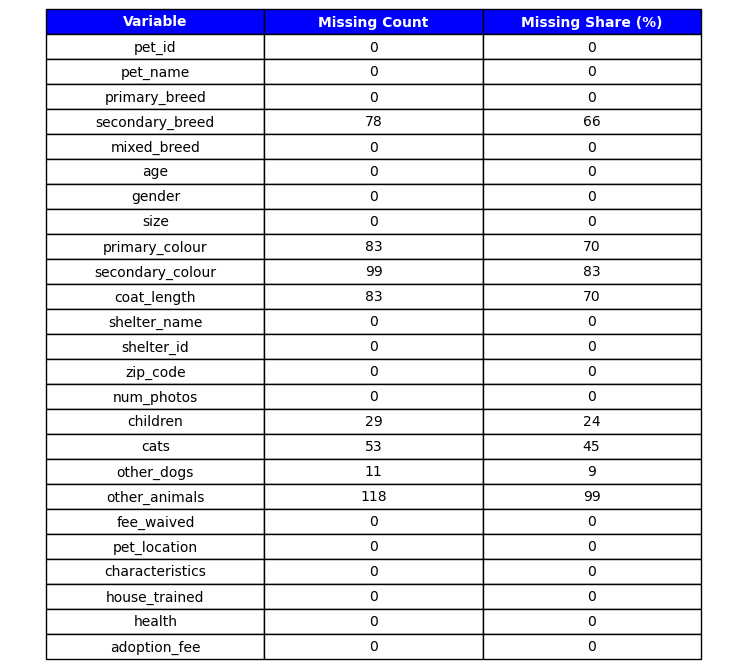

In [123]:

# Creating a formatted table 
fig, list_subfig = plt.subplots(figsize = (8,4))

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)


table = list_subfig.table(cellText=dogs_missing_table.values, 
                  colLabels=dogs_missing_table.columns, 
                  loc='center', cellLoc='center')

table.scale(0.9, 1.5)  
list_subfig.axis('off')

# Formating the table
table.auto_set_font_size(False)
table.set_fontsize(10) 

for (i, j), cell in table.get_celld().items():
    if i == 0:  
        cell.set_facecolor('blue')  
        cell.set_text_props(color='white', weight='bold', fontsize=10)  
    else:  
        pass
    cell.set_edgecolor('black')  

plt.show()

In [101]:
# Creating a copy
df_dog_info_copy = df_dog_info.copy()

In [102]:
# Replacing null values with appropriate text 
df_dog_info_copy['secondary_breed'] = df_dog_info_copy['secondary_breed'].fillna('None')
df_dog_info_copy['primary_colour'] = df_dog_info_copy['primary_colour'].fillna('Unknown')
df_dog_info_copy['secondary_colour'] = df_dog_info_copy['secondary_colour'].fillna('None')
df_dog_info_copy['coat_length'] = df_dog_info_copy['coat_length'].fillna('Unknown')
df_dog_info_copy['children'] = df_dog_info_copy['children'].fillna('Unknown')
df_dog_info_copy['cats'] = df_dog_info_copy['cats'].fillna('Unknown')
df_dog_info_copy['other_dogs'] = df_dog_info_copy['other_dogs'].fillna('Unknown')

# Dropping other animals column since most values are missing 
df_dog_clean = df_dog_info_copy.drop(columns = ['other_animals'])

### Value Consistency 

#### Pet Name

In [104]:
# Looking at structure of some of the pet names 
print(df_dog_clean['pet_name'].unique())

['Jackson' 'Candy' 'Marshmallow' 'Bowie' 'Ezra - Pending' 'Athena' 'Sven'
 'Storm' 'Dio' 'Freddy' 'Boulder' 'Runni Man' 'Magpie' 'Ariel' 'Blanco'
 'Abby' 'Petey*' 'Wiler' 'Emma May' 'Aunt Bea' 'Eleanor' 'Moochie*'
 'Faith' 'Tuck' 'Bella (Sweet, smaller girl looking for solo pup home)'
 "Nelly (Beautiful sweet & shy girl needs the love she's never known)"
 'Shadow (Sweet neglected boy looking for his hero!)'
 "Rupert (Mama Cookie's Litter)" 'Jewel' 'Cosmo the Charismatic'
 'Mumford - "What they don\'t tell you about pittbulls is that they have to have lots of snuggles!"'
 'Queen Bean, the devoted Death Row kill shelter dog SPARKLING with lavish love for people!'
 'Legend' 'Eugene' 'Luna' 'G.G.' 'Monty' 'D.C.' 'Bama' 'Reese' 'Poppy'
 'Mitzi' 'Jake' 'Otto' 'Timmy' 'Bijou' 'Sundae' 'Curry' 'Zuko' 'Zara'
 'Bitsy' 'Betsy' 'Karen' 'Camacho' 'Ruscio' 'Kya' 'Scott' 'Athena Pup'
 'Apollo' 'Bogey' 'Misha Foster or Adopter Urgently Needed' 'Osada'
 'Josie' 'Jolene' 'Pepe' 'Muskrat' 'Rocky' 'Mishka

In [105]:
# Function to clean names 
def clean_dog_name(name):

    # Matching valid names using RegEX
    cleaned_name = re.match(r'^[A-Za-z][A-Za-z\.]*', name.strip())
    
    # If a match is found then return the cleaned name, otherwise return the original string 
    if cleaned_name:
        return cleaned_name.group(0)
    else:
        return name.strip()

# Applying the cleaning function to the pet_name column
df_dog_clean['clean_pet_names'] = df_dog_clean['pet_name'].apply(clean_dog_name)

# Checking the results 
print(df_dog_clean['clean_pet_names'].unique())

['Jackson' 'Candy' 'Marshmallow' 'Bowie' 'Ezra' 'Athena' 'Sven' 'Storm'
 'Dio' 'Freddy' 'Boulder' 'Runni' 'Magpie' 'Ariel' 'Blanco' 'Abby' 'Petey'
 'Wiler' 'Emma' 'Aunt' 'Eleanor' 'Moochie' 'Faith' 'Tuck' 'Bella' 'Nelly'
 'Shadow' 'Rupert' 'Jewel' 'Cosmo' 'Mumford' 'Queen' 'Legend' 'Eugene'
 'Luna' 'G.G.' 'Monty' 'D.C.' 'Bama' 'Reese' 'Poppy' 'Mitzi' 'Jake' 'Otto'
 'Timmy' 'Bijou' 'Sundae' 'Curry' 'Zuko' 'Zara' 'Bitsy' 'Betsy' 'Karen'
 'Camacho' 'Ruscio' 'Kya' 'Scott' 'Apollo' 'Bogey' 'Misha' 'Osada' 'Josie'
 'Jolene' 'Pepe' 'Muskrat' 'Rocky' 'Mishka' 'Max' 'Layton' 'Iggy' 'Ivy'
 'Luca' 'Leroy' 'Volt' 'Laddie' 'Cookie' 'Odin' 'Harley' 'Patsy' 'Dodger'
 'Lady' 'Rosie' 'Keanu' 'Prince' 'Sadie' 'Orrelo' 'Sam' 'Rizzo'
 'Seabiscuit' 'Doreen' 'Piccolo' 'Tyson' 'Jett' 'Jojo' 'Romello' 'Dobbins'
 'Chico' 'Boomer' 'Dexter' 'Teddy' 'Cullen' 'Sugarfoot' 'Piper' 'Bingo'
 'Abraham' 'Avali' 'Jerry' 'Marie' 'Nalla' 'Kiya' 'Starla.' 'Roxie'
 'Ollie' 'Jaxon']


In [110]:
# Dropping original pet name column 
df_dog_clean = df_dog_clean.drop(columns = ['pet_name'])

#### Adoption Fee

In [106]:
# Looking at unique adoption fees to identify different structures 
print(df_dog_clean['adoption_fee'].unique())

['N/A' '450' '500' '$600.00' '$250.00' '$300.00' '$200.00' '$325.00'
 '$475.00' '$400.00' '$350.00' '$450.00' '$500.00' '$375.00']


In [107]:
# Using regular expression to make consistent structure
df_dog_clean['adoption_fee'] = df_dog_clean['adoption_fee'].replace({r'\$': ''}, regex=True)
# df_dog_clean['adoption_fee'] = df_dog_clean['adoption_fee'].replace('N/A', np.nan)

# Converting to numeric coerce errors to NaN
df_dog_clean['adoption_fee'] = pd.to_numeric(df_dog_clean['adoption_fee'], errors='coerce')

# Converting to nullable integer type
df_dog_clean['adoption_fee'] = df_dog_clean['adoption_fee'].astype('Int64')

# Verifying results 
print(df_dog_clean['adoption_fee'].unique())

<IntegerArray>
[<NA>, 450, 500, 600, 250, 300, 200, 325, 475, 400, 350, 375]
Length: 12, dtype: Int64


In [108]:
# Viewing datatypes
df_dog_clean.dtypes

pet_id              object
pet_name            object
primary_breed       object
secondary_breed     object
mixed_breed           bool
age                 object
gender              object
size                object
primary_colour      object
secondary_colour    object
coat_length         object
shelter_name        object
shelter_id          object
zip_code            object
num_photos           int64
children            object
cats                object
other_dogs          object
fee_waived            bool
pet_location        object
characteristics     object
house_trained       object
health              object
adoption_fee         Int64
clean_pet_names     object
dtype: object

In [109]:
display(df_dog_clean)

,pet_id,pet_name,primary_breed,secondary_breed,mixed_breed,age,gender,size,primary_colour,secondary_colour,...,children,cats,other_dogs,fee_waived,pet_location,characteristics,house_trained,health,adoption_fee,clean_pet_names
0,72096072,Jackson,Boxer,American Bulldog,True,Senior,Male,Medium,Brindle,None,...,Unknown,False,False,False,"Atlanta , GA","Friendly, Affectionate, Smart, Athletic, Food ...",Yes,"Vaccinations up to date, spayed / neutered.",<NA>,Jackson
1,73681457,Candy,Chiweenie,Mixed Breed,True,Baby,Female,Small,Unknown,None,...,True,True,True,False,"Atlanta , GA",N/A,N/A,Vaccinations up to date.,450,Candy
2,73681390,Marshmallow,Great Pyrenees,None,True,Baby,Female,Large,Unknown,None,...,True,True,True,False,"Atlanta , GA",N/A,N/A,Vaccinations up to date.,500,Marshmallow
3,73491201,Bowie,Labrador Retriever,Mixed Breed,True,Baby,Male,Large,Unknown,None,...,True,Unknown,True,False,"Atlanta , GA",N/A,Yes,Vaccinations up to date.,450,Bowie
4,70952437,Ezra - Pending,Italian Greyhound,American Bulldog,True,Adult,Male,Medium,Unknown,None,...,Unknown,True,False,False,"Atlanta, GA",N/A,Yes,"Vaccinations up to date, spayed / neutered.",<NA>,Ezra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,70115419,Kiya,Rottweiler,None,True,Young,Female,Medium,Unknown,None,...,True,Unknown,True,False,"Decatur, GA",N/A,Yes,Spayed / neutered.,<NA>,Kiya
115,69947262,Starla. Looking for Foster or Adopter,Border Collie,Australian Cattle Dog / Blue Heeler,True,Young,Female,Medium,Unknown,None,...,True,Unknown,True,False,"Decatur, GA",N/A,Yes,Spayed / neutered.,<NA>,Starla.
116,69703926,Roxie,Terrier,None,True,Young,Female,Medium,Unknown,None,...,True,Unknown,True,False,"Decatur, GA",N/A,Yes,N/A,<NA>,Roxie
117,69703927,Ollie,Terrier,None,True,Young,Male,Medium,Unknown,None,...,True,Unknown,True,False,"Decatur, GA",N/A,Yes,N/A,<NA>,Ollie


### Numeric Summary

In [111]:
df_dog_clean.describe()

,num_photos,adoption_fee
count,119.000000,38.0
mean,3.731092,343.421053
std,1.394283,107.754132
min,0.000000,200.0
25%,3.000000,250.0
50%,3.000000,325.0
75%,4.500000,437.5
max,12.000000,600.0


There are only two numerical fields in the data at the moment, the number of photos that the dog has on their detail page, and the adoption fee (sometimes not provided).
- The mean number of a photos a dog has on their page is 3.7, with some variation, a few listings having no photos and some having up to 12
- The mean adoption fee of a dog is $343, with a wide spread in adoption fees, from $200 to $600

In [124]:
# Converting to csv
df_dog_clean.to_csv('dog_data_clean.csv')